In [1]:
from funcs import *
from sklearn.datasets import load_boston
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler

import sys

## Sample Data to Test Nueral Network

In [2]:
X, y = load_boston(return_X_y=True)

scaler = StandardScaler()
X_std = scaler.fit_transform(X)

In [3]:
x = np.array([[1, 2], [3, 4]])
x

array([[1, 2],
       [3, 4]])

array([[ 1,  4],
       [ 9, 16]])

In [177]:
x_sq = x ** 2
x_sq
np.sum(x_sq)

30

## Neural Network Class

In [2]:
class NeuralNetwork:
    
    def __init__(self, layers=None, nodes=None, nnodes=None, 
                 activations=[], activationFn="relu", batchSize=50, 
                 lr=.001, lr_type="constant", power_t=.5,
                 annealing_rate=.999, max_epoch=200, momentum=.9, 
                 tol=0.0001, alpha=.0001, shuffle=False, 
                 early_stopping=False, num_epochs_stop=50):
        
        if layers != None:
            self.layers = layers # total number of hidden layers
        else:
            self.layers = len(nodes)

        # an int array of size [0, ..., Layers + 1]
        # Nodes[0] shall represent the input size (typically 50)
        # Nodes[Layers + 1] shall represent the output size (typically 1)
        # all other Nodes represent the number of nodes (or width) in the hidden layer i
        self.nodes = nodes
        if nodes != None:
            self.nodes.insert(0, batchSize)
            self.nodes.append(1)
        
        # alternative to nodes where each hidden layer of the nueral network is the same size
        self.nnodes = nnodes
        if nnodes != None:
            self.nodes = []
            self.nodes.append(batchSize)
            for i in range(layers):
                self.nodes.append(nnodes)
            self.nodes.append(1)
        
        # activations[i] values are labels indicating the activation function used in layer i
        self.activations = activations
        self.activationFn = activationFn
        if activationFn != "":
            self.activations = [activationFn] * self.layers
        
        self.batchSize = batchSize
        self.lr = lr
        self.lr_type = lr_type
        self.power_t = power_t
        self.annealing_rate = annealing_rate
        self.max_epoch = max_epoch
        self.mu = momentum
        self.tol = tol
        self.alpha = alpha
        self.shuffle = shuffle
        
        if early_stopping == False:
            self.num_epochs_stop = max_epoch
        else:
            self.num_epochs_stop = num_epochs_stop
    
        self.layer_values = [None] * (self.layers + 2)
        self.iters = 0
        self.epochs = 0
                
    def validateHyperParams(self):
        
        if self.layers != (len(self.nodes) - 2):
            raise ValueError("layers must be equal to the number of hidden layers, got %s." % self.layers)
        if self.nnodes != None and self.nnodes <= 0:
            raise ValueError("nnodes must be > 0, got %s." % self.nnodes)
        if self.lr <= 0 or self.lr > 1:
            raise ValueError("lr must be in (0, 1], got %s." % self.lr)
            
        if self.lr_type not in ["constant", "invscaling", "annealing", "adaptive"]:
            raise ValueError("lr_type is not valid" % self.lr_type
                            + "\nAvailable lr types: constant, invscaling, adaptive")
            
        if self.max_epoch <= 0:
            raise ValueError("max_iter must be > 0, got %s." % self.max_epoch)
               
        activation_functions = list(ACTIVATIONS.keys())
        if self.activationFn != "":
            if self.activationFn not in activation_functions:
                raise ValueError("%s is not an activation function" % self.activationFn
                                + "\nAvailable activation functions: relu, leaky_relu, sigmoid, tanh")
    
    def initialize_weights(self, M):
        weights = []
        
        for i in range(self.layers + 1):
            if i == 0:
                input_size = M # special case for w1
            else:
                input_size = self.nodes[i]
            output_size = self.nodes[i + 1]
            
            # Xavier (Glorot) Initialization
            if self.activationFn == "tanh":
                target_variance = 2 / (input_size + output_size)
                w_i = np.random.normal(loc= 0, scale = np.sqrt(target_variance), size=(input_size, output_size))
            # He Initialization
            elif self.activationFn == "relu":
                target_variance = 2 / input_size
                w_i = np.random.normal(loc= 0, scale = np.sqrt(target_variance), size=(input_size, output_size))
            # Random Uniform
            else:
                w_i = np.random.uniform(-1/np.sqrt(input_size), 1/np.sqrt(input_size))
                #w_i = np.random.normal(size=(input_size, output_size))
            w_i = np.round(w_i, 2)
            w_i[input_size - 1:] = 0 # initialize bias to 0
            weights.append(w_i)
        return weights
    
    # returns the weight term for L2 regularization
    def get_weight_term(self):
        weight_term = 0
        for i in range(len(self.weights)):
            weight_term = np.sum(self.weights[i] ** 2)
        return weight_term
        
    def forward_pass(self, X_batch, y_batch):
        
        self.layer_values[0] = X_batch
        
        # calculate hidden layers
        for i in range(self.layers):
            X = self.layer_values[i]
            weights = self.weights[i]
            h_layer = X.dot(weights)
            
            # apply activation function
            activation_fn = ACTIVATIONS[self.activations[i]]
            activation_fn(h_layer)
            self.layer_values[i + 1] = h_layer
            
        
        # calculate predictions
        X = self.layer_values[self.layers] # values in last hidden layer
        weights = self.weights[self.layers]
        y_pred = X.dot(weights)
        y_pred = y_pred.flatten()
        
        # calculate the l2 loss
        l2_loss = 0
        # only need predictions once we have fit the data
        if isinstance(y_batch, np.ndarray): 
            l2_loss = squared_loss(y_pred, y_batch) # l2
            weight_term = self.get_weight_term()
            l2_loss += self.alpha * weight_term # l2 regularization
            self.layer_values[self.layers + 1] = l2_loss
        
        return l2_loss, y_pred
    
    
    def backward_pass(self, y_pred, y_batch):
        
        # loss layer
        J = squared_loss_derivative(y_pred, y_batch, self.batchSize)
        J = np.reshape(J, (len(J), 1))
        
        J_weights = [None] * (self.layers + 1)
        
        # output layer
        # jacobian w.r.t. weights
        x_t = self.layer_values[self.layers].T
        J_wi = x_t.dot(J)
        J_weights[self.layers] = J_wi
        
        # update jacobian at output layer
        w_t = self.weights[self.layers].T
        w_t = np.delete(w_t, w_t.shape[1] - 1, 1) # take out the bias
        J = np.dot(J, w_t)
        zeros = [0] * len(J)
        zeros = np.reshape(zeros, (len(J), 1))
        J = np.append(J, zeros, axis=1)
        
        # iterate through hidden layers backwards
        for i in range(self.layers, 0 , -1):
            # update jacobian at activation layer
            d_activation_fn = DERIVATIVES[self.activations[i - 1]]
            d_activation_fn(self.layer_values[i], J)
            
            # hidden layer
            # jacobian w.r.t. weights
            x_t = self.layer_values[i - 1].T
            J_wi = x_t.dot(J)
            J_weights[i - 1] = J_wi
            
            # jacobian w.r.t. inputs
            w_t = self.weights[i - 1].T
            w_t = np.delete(w_t, w_t.shape[1] - 1, 1)
            J = np.dot(J, w_t)
            zeros = [0] * len(J)
            zeros = np.reshape(zeros, (len(J), 1))
            J = np.append(J, zeros, axis=1)
            
            
        # initialize velocity to 0
        if self.epochs == 0 and self.iters == 0:
            self.velocity = []
            for i in range(len(J_weights)):
                n_rows = J_weights[i].shape[0]
                n_cols = J_weights[i].shape[1]
                vel_i = np.zeros((n_rows, n_cols))
                self.velocity.append(vel_i)
        
        for i in range(len(J_weights)):
            self.velocity[i] = self.mu * self.velocity[i] - self.lr * J_weights[i]
            self.weights[i] += self.velocity[i]
      
    
    def fit(self, X_train, y_train):
        
        self.validateHyperParams()
        # convert to numpy arrays
        if isinstance(X_train, pd.DataFrame):
            X_train = X_train.to_numpy()
            
        if isinstance(y_train, pd.Series):
            y_train = y_train.to_numpy()
            
        # add ones for bias
        ones = [1] * len(X_train)
        ones = np.reshape(ones, (len(X_train), 1))
        X_train = np.append(X_train, ones, axis=1)
        
        # save 10% for validation
        val_rows = round(len(X_train) * .1)
        X_val = X_train[:val_rows, :]
        y_val = y_train[:val_rows]
        
        X_train = X_train[val_rows:, :]
        y_train = y_train[val_rows:]
        
        # initalize weights on first iteration
        M = X_train.shape[1] # M = number of features
        self.weights = self.initialize_weights(M)
        
        best_v_loss = np.inf
        n_epoch_no_change = 0 
        while (self.epochs < self.max_epoch and n_epoch_no_change <= self.num_epochs_stop):
            # ONE EPOCH 
            last_idx = 0
            if self.shuffle == True: # shuffle data after every epoch, if specified 
                np.random.shuffle(X_train)
            while (last_idx < len(X_train)):
                first_idx = self.iters * self.batchSize
                remaining_rows = len(X_train) - first_idx
                last_idx = first_idx + min(self.batchSize, remaining_rows)
                X_batch = X_train[first_idx: last_idx, :]
                y_batch = y_train[first_idx: last_idx]

                loss, y_pred = self.forward_pass(X_batch, y_batch)
                self.backward_pass(y_pred, y_batch)
                self.iters += 1
            
            # trainig and validation loss after one epoch
            t_loss, y_pred = self.forward_pass(X_train, y_train)
            v_loss, y_pred = self.forward_pass(X_val, y_val)
            print("epoch:", self.epochs)
            print("training loss:", t_loss)
            print("validation loss:", v_loss)
            
            self.iters = 0 # start over, next epoch
            self.epochs += 1
            
            # decrease the learning rate by one of three methods, if specified
            if self.lr_type == "invscaling":
                self.lr = self.lr/pow(self.epochs, self.power_t)
            elif self.lr_type == "annealing":
                self.lr = self.lr * self.annealing_rate
            elif self.lr_type == "adaptive":
                if n_epoch_no_change >= 2: 
                    self.lr = self.lr/5
                
            # stops when validation loss doesn't improve for num_epochs_stop
            if best_v_loss - v_loss < self.tol: 
                n_epoch_no_change += 1
            else:
                n_epoch_no_change = 0
            # update best_v_loss
            if v_loss < best_v_loss:
                best_v_loss = v_loss
            
            
        
    def predict(self, X_test):
        
        # convert to numpy array
        if isinstance(X_test, pd.DataFrame):
            X_test = X_test.to_numpy()
        
        # add ones for bias
        ones = [1] * len(X_test)
        ones = np.reshape(ones, (len(X_test), 1))
        X_test = np.append(X_test, ones, axis=1)
        
        loss, y_pred = self.forward_pass(X_test, None)
        return y_pred
        

## Running Nueral Network on Practice Data

In [3]:
nodes = [100, 50, 100] # use to specify a number of hidden nodes per layer
activations = [] # use if you want a diff activationFn per layer

nn = NeuralNetwork(layers=3, nnodes=100, batchSize=50, 
                   activationFn="tanh", lr=.001, lr_type="constant", 
                   max_epoch=2000, momentum=0.9, early_stopping=False)
nn.fit(X_std, y)

NameError: name 'X_std' is not defined

## Running Neural Network on Actual Data

In [3]:
russia_df = pd.read_csv("russian_housing.csv")

scaler = StandardScaler()
X_std = scaler.fit_transform(russia_df.drop(["timestamp", "price_doc"], axis=1))
y = russia_df["price_doc"]

In [5]:
nodes = [50, 75, 100] # use to specify a number of hidden nodes per layer
lrs = [0.00001, 0.000001, 0.0000001, 0.00000001]
activations = ["relu"] # use if you want a diff activationFn per layer

means = []

for nod in nodes:
    for ls in lrs:
        print("Nodes:", nod)
        print("Learning Rate:", ls)
        nn = NeuralNetwork(layers=3, nnodes=nod, batchSize=50, 
                   activationFn="tanh", lr=ls, lr_type="constant", 
                   max_epoch=2000, momentum=0.9, early_stopping=True)
        nn.fit(X_std, y)
        
        mae = mean_absolute_error(y, nn.predict(X_std))
        means.append(mae)
        print('Mean absolute error: $%0.2f'%(mae*1000))

# nn = NeuralNetwork(layers=3, nnodes=50, batchSize=50, 
#                    activationFn="tanh", lr=.000001, lr_type="constant", 
#                    max_epoch=2000, momentum=0.9, early_stopping=True)
# nn.fit(X_std, y)
print(means)

Nodes: 50
Learning Rate: 1e-05
epoch: 0
training loss: 42277064794920.83
validation loss: 53312912796533.36
epoch: 1
training loss: 39322610335220.64
validation loss: 46051527583366.95
epoch: 2
training loss: 36349980359871.586
validation loss: 38941246125926.1
epoch: 3
training loss: 35589172107292.664
validation loss: 39123982245002.38
epoch: 4
training loss: 35070174052697.543
validation loss: 39845954259681.09
epoch: 5
training loss: 34636499933404.15
validation loss: 40460810732610.9
epoch: 6
training loss: 34274597007680.26
validation loss: 40992627252081.43
epoch: 7
training loss: 33970600262322.84
validation loss: 41449313544701.37
epoch: 8
training loss: 33713329260458.84
validation loss: 41837627363459.67
epoch: 9
training loss: 33493920161713.44
validation loss: 42164107651213.23
epoch: 10
training loss: 33305342365939.69
validation loss: 42435019965959.766
epoch: 11
training loss: 33142006506115.28
validation loss: 42656274568070.625
epoch: 12
training loss: 32999456822103.

epoch: 49
training loss: 30276243483891.332
validation loss: 24591560635123.016
epoch: 50
training loss: 30271934324900.453
validation loss: 24607592367945.85
epoch: 51
training loss: 30267770498313.85
validation loss: 24622316051156.543
epoch: 52
training loss: 30263743430547.707
validation loss: 24635774697635.96
epoch: 53
training loss: 30259845089612.113
validation loss: 24648010321999.473
epoch: 54
training loss: 30256067950902.75
validation loss: 24659063918399.402
epoch: 55
training loss: 30252404965079.863
validation loss: 24668975447739.41
epoch: 56
training loss: 30248849527885.055
validation loss: 24677783832446.98
epoch: 57
training loss: 30245395451994.863
validation loss: 24685526957299.863
epoch: 58
training loss: 30242036940502.86
validation loss: 24692241675010.07
epoch: 59
training loss: 30238768562125.33
validation loss: 24697963815645.316
epoch: 60
training loss: 30235585228045.47
validation loss: 24702728199042.945
epoch: 61
training loss: 30232482170058.95
validat

epoch: 88
training loss: 31600455651522.992
validation loss: 20733760391775.543
epoch: 89
training loss: 31593845594241.254
validation loss: 20706281121038.85
epoch: 90
training loss: 31587427548245.438
validation loss: 20679635362615.188
epoch: 91
training loss: 31581192662150.402
validation loss: 20653798891685.01
epoch: 92
training loss: 31575132501864.098
validation loss: 20628748265945.137
epoch: 93
training loss: 31569239030900.87
validation loss: 20604460797195.336
epoch: 94
training loss: 31563504591623.55
validation loss: 20580914524064.92
epoch: 95
training loss: 31557921887370.332
validation loss: 20558088185830.094
epoch: 96
training loss: 31552483965424.55
validation loss: 20535961197275.305
epoch: 97
training loss: 31547184200787.97
validation loss: 20514513624553.844
epoch: 98
training loss: 31542016280719.22
validation loss: 20493726162004.96
epoch: 99
training loss: 31536974190001.85
validation loss: 20473580109886.66
epoch: 100
training loss: 31532052196906.992
valida

epoch: 191
training loss: 31267916154874.47
validation loss: 19976634101890.62
epoch: 192
training loss: 31265684046545.83
validation loss: 19977869478517.496
epoch: 193
training loss: 31263457042026.81
validation loss: 19979157932362.31
epoch: 194
training loss: 31261235072704.49
validation loss: 19980498097553.848
epoch: 195
training loss: 31259018072838.16
validation loss: 19981888641959.72
epoch: 196
training loss: 31256805979424.03
validation loss: 19983328266321.668
epoch: 197
training loss: 31254598732066.434
validation loss: 19984815703414.51
epoch: 198
training loss: 31252396272854.98
validation loss: 19986349717227.973
epoch: 199
training loss: 31250198546247.656
validation loss: 19987929102170.766
epoch: 200
training loss: 31248005498959.344
validation loss: 19989552682296.254
epoch: 201
training loss: 31245817079855.664
validation loss: 19991219310549.06
epoch: 202
training loss: 31243633239851.875
validation loss: 19992927868031.99
epoch: 203
training loss: 31241453931816.

epoch: 69
training loss: 35318743083141.74
validation loss: 30648319244244.43
epoch: 70
training loss: 35291284291883.125
validation loss: 30608573867444.285
epoch: 71
training loss: 35268676590302.66
validation loss: 31217141731480.613
epoch: 72
training loss: 35284789438764.6
validation loss: 31362559647415.355
epoch: 73
training loss: 35292610651121.32
validation loss: 31276219096747.266
epoch: 74
training loss: 35314780833932.04
validation loss: 31555728757713.04
epoch: 75
training loss: 35249098778724.36
validation loss: 31276914403886.805
epoch: 76
training loss: 35229307005607.76
validation loss: 31380863187921.27
epoch: 77
training loss: 35183556563625.785
validation loss: 31518516172573.977
epoch: 78
training loss: 35143475692730.0
validation loss: 32122997473898.812
epoch: 79
training loss: 35079865653024.418
validation loss: 31609567394745.492
epoch: 80
training loss: 35068832207979.1
validation loss: 30839224796010.344
epoch: 81
training loss: 35034793170487.188
validation 

epoch: 172
training loss: 33430467434032.62
validation loss: 27843143406618.727
epoch: 173
training loss: 33416761770250.383
validation loss: 27819968673413.324
epoch: 174
training loss: 33403125625935.312
validation loss: 27796881262191.15
epoch: 175
training loss: 33389558645925.207
validation loss: 27773880808745.38
epoch: 176
training loss: 33376060476872.418
validation loss: 27750966950520.855
epoch: 177
training loss: 33362630767234.645
validation loss: 27728139326606.184
epoch: 178
training loss: 33349269167265.68
validation loss: 27705397577725.78
epoch: 179
training loss: 33335975329006.242
validation loss: 27682741346232.03
epoch: 180
training loss: 33322748906274.848
validation loss: 27660170276097.445
epoch: 181
training loss: 33309589554658.723
validation loss: 27637684012906.867
epoch: 182
training loss: 33296496931504.766
validation loss: 27615282203849.684
epoch: 183
training loss: 33283470695910.555
validation loss: 27592964497712.156
epoch: 184
training loss: 33270510

epoch: 275
training loss: 32328409813650.152
validation loss: 25856835409896.28
epoch: 276
training loss: 32319441673048.89
validation loss: 25858232282723.78
epoch: 277
training loss: 32311030006554.344
validation loss: 25860482990106.9
epoch: 278
training loss: 32302977484896.555
validation loss: 25844833619203.05
epoch: 279
training loss: 32294965612338.965
validation loss: 25829240761804.832
epoch: 280
training loss: 32286994165512.746
validation loss: 25813704248956.082
epoch: 281
training loss: 32279062937941.13
validation loss: 25798223854959.53
epoch: 282
training loss: 32271171724202.074
validation loss: 25782799355109.676
epoch: 283
training loss: 32263320319922.9
validation loss: 25767430525687.934
epoch: 284
training loss: 32255508521774.92
validation loss: 25752117143957.902
epoch: 285
training loss: 32247736127468.098
validation loss: 25736858988160.56
epoch: 286
training loss: 32240002935745.766
validation loss: 25721655837509.49
epoch: 287
training loss: 32232308746379.

epoch: 378
training loss: 31669416977142.457
validation loss: 24702999821075.824
epoch: 379
training loss: 31664556574191.273
validation loss: 24692244372638.957
epoch: 380
training loss: 31659720471238.203
validation loss: 24681526299346.8
epoch: 381
training loss: 31654908544377.57
validation loss: 24670845457958.03
epoch: 382
training loss: 31650120670335.617
validation loss: 24660201705841.363
epoch: 383
training loss: 31645356726467.324
validation loss: 24649594900972.74
epoch: 384
training loss: 31640616590753.19
validation loss: 24639024901932.54
epoch: 385
training loss: 31635900141796.05
validation loss: 24628491567902.8
epoch: 386
training loss: 31631207258817.875
validation loss: 24617994758664.473
epoch: 387
training loss: 31626537821656.637
validation loss: 24607534334594.613
epoch: 388
training loss: 31621891710763.17
validation loss: 24597110156663.74
epoch: 389
training loss: 31617268807198.035
validation loss: 24586722086432.99
epoch: 390
training loss: 31612668992628.

epoch: 481
training loss: 31277064322268.434
validation loss: 23768657573254.84
epoch: 482
training loss: 31274154780282.258
validation loss: 23761095896767.066
epoch: 483
training loss: 31271259591541.062
validation loss: 23753559604423.84
epoch: 484
training loss: 31268378682870.12
validation loss: 23746048603206.594
epoch: 485
training loss: 31265511981467.926
validation loss: 23738562800478.44
epoch: 486
training loss: 31262659414904.285
validation loss: 23731102103982.477
epoch: 487
training loss: 31259820911118.42
validation loss: 23723666421840.062
epoch: 488
training loss: 31256996398417.082
validation loss: 23716255662549.176
epoch: 489
training loss: 31254185805472.66
validation loss: 23708869734982.645
epoch: 490
training loss: 31251389061321.367
validation loss: 23701508548386.543
epoch: 491
training loss: 31248606095361.336
validation loss: 23694172012378.484
epoch: 492
training loss: 31245836837350.785
validation loss: 23686860036945.96
epoch: 493
training loss: 312430812

epoch: 584
training loss: 31041334473104.047
validation loss: 23108246036431.434
epoch: 585
training loss: 31039577299656.945
validation loss: 23102870896305.086
epoch: 586
training loss: 31037828605241.523
validation loss: 23097513294557.777
epoch: 587
training loss: 31036088346643.46
validation loss: 23092173169774.53
epoch: 588
training loss: 31034356480868.82
validation loss: 23086850460782.26
epoch: 589
training loss: 31032632965142.977
validation loss: 23081545106648.723
epoch: 590
training loss: 31030917756909.414
validation loss: 23076257046681.48
epoch: 591
training loss: 31029210813828.695
validation loss: 23070986220426.836
epoch: 592
training loss: 31027512093777.29
validation loss: 23065732567668.832
epoch: 593
training loss: 31025821554846.445
validation loss: 23060496028428.17
epoch: 594
training loss: 31024139155341.13
validation loss: 23055276542961.24
epoch: 595
training loss: 31022464853778.824
validation loss: 23050074051759.03
epoch: 596
training loss: 310207986088

epoch: 687
training loss: 30896877683205.254
validation loss: 22867803549015.297
epoch: 688
training loss: 30895798602420.02
validation loss: 22864000211298.71
epoch: 689
training loss: 30894724545320.484
validation loss: 22860208960894.29
epoch: 690
training loss: 30893655486367.293
validation loss: 22856429757390.797
epoch: 691
training loss: 30892591400151.04
validation loss: 22852662560529.023
epoch: 692
training loss: 30891532261391.586
validation loss: 22848907330201.113
epoch: 693
training loss: 30890478044937.34
validation loss: 22845164026449.95
epoch: 694
training loss: 30889428725764.46
validation loss: 22841432609468.523
epoch: 695
training loss: 30888384278975.88
validation loss: 22837713039599.277
epoch: 696
training loss: 30887344679799.64
validation loss: 22834005277333.53
epoch: 697
training loss: 30886309903584.254
validation loss: 22830309283310.81
epoch: 698
training loss: 30885279925773.98
validation loss: 22826625018318.242
epoch: 699
training loss: 30884254721532

epoch: 790
training loss: 30806054238712.73
validation loss: 22556900053628.12
epoch: 791
training loss: 30805378271425.496
validation loss: 22554154805286.785
epoch: 792
training loss: 30804705283056.633
validation loss: 22551418171925.895
epoch: 793
training loss: 30804035258473.133
validation loss: 22548690125920.36
epoch: 794
training loss: 30803368182619.03
validation loss: 22545970639744.406
epoch: 795
training loss: 30802704040514.97
validation loss: 22543259685971.19
epoch: 796
training loss: 30802042817257.883
validation loss: 22540557237272.43
epoch: 797
training loss: 30801384498020.535
validation loss: 22537863266417.957
epoch: 798
training loss: 30800729068051.184
validation loss: 22535177746275.34
epoch: 799
training loss: 30800076512673.145
validation loss: 22532500649809.504
epoch: 800
training loss: 30799426817284.484
validation loss: 22529831950082.332
epoch: 801
training loss: 30798779967357.562
validation loss: 22527171620252.26
epoch: 802
training loss: 30798135948

epoch: 893
training loss: 30749710492648.38
validation loss: 22314914917424.613
epoch: 894
training loss: 30749273910828.73
validation loss: 22312927836881.17
epoch: 895
training loss: 30748839092531.64
validation loss: 22310946984023.766
epoch: 896
training loss: 30748406028810.824
validation loss: 22308972339633.574
epoch: 897
training loss: 30747974710765.523
validation loss: 22307003884557.83
epoch: 898
training loss: 30747545129540.3
validation loss: 22305041599709.574
epoch: 899
training loss: 30747117276324.777
validation loss: 22303085466067.406
epoch: 900
training loss: 30746691142353.457
validation loss: 22301135464675.21
epoch: 901
training loss: 30746266718905.414
validation loss: 22299191576641.93
epoch: 902
training loss: 30745843997304.17
validation loss: 22297253783141.285
epoch: 903
training loss: 30745422968917.367
validation loss: 22295322065411.555
epoch: 904
training loss: 30745003625156.625
validation loss: 22293396404755.305
epoch: 905
training loss: 307445859574

epoch: 996
training loss: 30712606815112.84
validation loss: 22139831962111.78
epoch: 997
training loss: 30712312005406.695
validation loss: 22138396018974.562
epoch: 998
training loss: 30712018240712.406
validation loss: 22136964630242.875
epoch: 999
training loss: 30711725515741.2
validation loss: 22135537782333.17
epoch: 1000
training loss: 30711433825231.2
validation loss: 22134115461706.605
epoch: 1001
training loss: 30711143163947.34
validation loss: 22132697654868.88
epoch: 1002
training loss: 30710853526681.188
validation loss: 22131284348370.047
epoch: 1003
training loss: 30710564908250.836
validation loss: 22129875528804.375
epoch: 1004
training loss: 30710277303500.75
validation loss: 22128471182810.156
epoch: 1005
training loss: 30709990707301.633
validation loss: 22127071297069.586
epoch: 1006
training loss: 30709705114550.3
validation loss: 22125675858308.562
epoch: 1007
training loss: 30709420520169.566
validation loss: 22124284853296.55
epoch: 1008
training loss: 307091

epoch: 1098
training loss: 30687114868503.05
validation loss: 22014670253256.742
epoch: 1099
training loss: 30686903501308.38
validation loss: 22013635915663.805
epoch: 1100
training loss: 30686692757507.66
validation loss: 22012604951468.32
epoch: 1101
training loss: 30686482633958.344
validation loss: 22011577350899.527
epoch: 1102
training loss: 30686273127533.906
validation loss: 22010553104217.543
epoch: 1103
training loss: 30686064235123.695
validation loss: 22009532201713.242
epoch: 1104
training loss: 30685855953632.93
validation loss: 22008514633708.195
epoch: 1105
training loss: 30685648279982.574
validation loss: 22007500390554.492
epoch: 1106
training loss: 30685441211109.25
validation loss: 22006489462634.676
epoch: 1107
training loss: 30685234743965.188
validation loss: 22005481840361.645
epoch: 1108
training loss: 30685028875518.14
validation loss: 22004477514178.492
epoch: 1109
training loss: 30684823602751.27
validation loss: 22003476474558.477
epoch: 1110
training los

epoch: 1200
training loss: 30487517903645.785
validation loss: 22482498164551.38
epoch: 1201
training loss: 30486965291011.934
validation loss: 22482039967083.316
epoch: 1202
training loss: 30486413396312.76
validation loss: 22481585133166.42
epoch: 1203
training loss: 30485862216226.867
validation loss: 22481133653265.574
epoch: 1204
training loss: 30485311747449.27
validation loss: 22480685517875.49
epoch: 1205
training loss: 30484761986691.2
validation loss: 22480240717520.895
epoch: 1206
training loss: 30484212930679.793
validation loss: 22479799242757.184
epoch: 1207
training loss: 30483664576157.156
validation loss: 22479361084172.066
epoch: 1208
training loss: 30483116919877.48
validation loss: 22478926232390.42
epoch: 1209
training loss: 30482569958591.49
validation loss: 22478494678089.68
epoch: 1210
training loss: 30482023688867.59
validation loss: 22478066412058.71
epoch: 1211
training loss: 30481478057590.73
validation loss: 22477641425369.914
epoch: 1212
training loss: 304

epoch: 28
training loss: 35471908520098.34
validation loss: 35911010590026.78
epoch: 29
training loss: 35471646245686.22
validation loss: 35892226836278.75
epoch: 30
training loss: 35471402378332.97
validation loss: 35874515497042.055
epoch: 31
training loss: 35471175349486.945
validation loss: 35857817972872.09
epoch: 32
training loss: 35470963694870.1
validation loss: 35842077807079.33
epoch: 33
training loss: 35470766059673.36
validation loss: 35827240951548.45
epoch: 34
training loss: 35470581198434.77
validation loss: 35813255899874.55
epoch: 35
training loss: 35470407971573.555
validation loss: 35800073730384.13
epoch: 36
training loss: 35470245339930.09
validation loss: 35787648088809.78
epoch: 37
training loss: 35470092358225.55
validation loss: 35775935131385.414
epoch: 38
training loss: 35469948168050.04
validation loss: 35764893442802.9
epoch: 39
training loss: 35469811990777.3
validation loss: 35754483939026.48
epoch: 40
training loss: 35469683120658.04
validation loss: 357

epoch: 80
training loss: 32940420435900.664
validation loss: 27409093361928.91
epoch: 81
training loss: 32934550311926.375
validation loss: 27388189421930.355
epoch: 82
training loss: 32928746785870.047
validation loss: 27367463095058.66
epoch: 83
training loss: 32923005618169.44
validation loss: 27346907271291.207
epoch: 84
training loss: 32917322882964.71
validation loss: 27326515240372.402
epoch: 85
training loss: 32911694944893.453
validation loss: 27306280666560.723
epoch: 86
training loss: 32906118437597.906
validation loss: 27286197565088.62
epoch: 87
training loss: 32900590243818.13
validation loss: 27266260280214.16
epoch: 88
training loss: 32895107476954.242
validation loss: 27246463464752.066
epoch: 89
training loss: 32889667463989.668
validation loss: 27226802060980.363
epoch: 90
training loss: 32884267729674.79
validation loss: 27207271282825.508
epoch: 91
training loss: 32878905981878.35
validation loss: 27187866599236.71
epoch: 92
training loss: 32873580098020.465
valida

epoch: 183
training loss: 32453292457683.785
validation loss: 25687080487502.723
epoch: 184
training loss: 32449125004136.355
validation loss: 25672713600391.61
epoch: 185
training loss: 32444965948365.387
validation loss: 25658378409101.91
epoch: 186
training loss: 32440815272561.902
validation loss: 25644074774569.023
epoch: 187
training loss: 32436672959008.973
validation loss: 25629802560640.785
epoch: 188
training loss: 32432538990075.27
validation loss: 25615561633974.11
epoch: 189
training loss: 32428413348209.246
validation loss: 25601351863935.613
epoch: 190
training loss: 32424296015933.684
validation loss: 25587173122506.05
epoch: 191
training loss: 32420186975840.895
validation loss: 25573025284188.367
epoch: 192
training loss: 32416086210588.21
validation loss: 25558908225919.277
epoch: 193
training loss: 32411993702893.93
validation loss: 25544821826984.15
epoch: 194
training loss: 32407909435533.656
validation loss: 25530765968935.16
epoch: 195
training loss: 32403833391

epoch: 286
training loss: 32075624913275.895
validation loss: 24381693665210.105
epoch: 287
training loss: 32072304374344.527
validation loss: 24370278203245.402
epoch: 288
training loss: 32068990449140.457
validation loss: 24358887210723.777
epoch: 289
training loss: 32065683124003.184
validation loss: 24347520598865.418
epoch: 290
training loss: 32062382385296.426
validation loss: 24336178280428.043
epoch: 291
training loss: 32059088219407.426
validation loss: 24324860169654.082
epoch: 292
training loss: 32055800612746.438
validation loss: 24313566182219.863
epoch: 293
training loss: 32052519551746.207
validation loss: 24302296235186.688
epoch: 294
training loss: 32049245022861.547
validation loss: 24291050246953.664
epoch: 295
training loss: 32045977012568.953
validation loss: 24279828137212.31
epoch: 296
training loss: 32042715507366.355
validation loss: 24268629826902.832
epoch: 297
training loss: 32039460493772.777
validation loss: 24257455238172.008
epoch: 298
training loss: 320

epoch: 389
training loss: 31766031602983.96
validation loss: 23322718871762.7
epoch: 390
training loss: 31763324399939.773
validation loss: 23313499206642.453
epoch: 391
training loss: 31760622520810.52
validation loss: 23304298371110.406
epoch: 392
training loss: 31757925954301.855
validation loss: 23295116324538.99
epoch: 393
training loss: 31755234689143.293
validation loss: 23285953026416.867
epoch: 394
training loss: 31752548714088.027
validation loss: 23276808436347.637
epoch: 395
training loss: 31749868017913.023
validation loss: 23267682514048.523
epoch: 396
training loss: 31747192589418.906
validation loss: 23258575219349.156
epoch: 397
training loss: 31744522417429.96
validation loss: 23249486512190.383
epoch: 398
training loss: 31741857490794.098
validation loss: 23240416352623.07
epoch: 399
training loss: 31739197798382.8
validation loss: 23231364700807.02
epoch: 400
training loss: 31736543329091.105
validation loss: 23222331517009.836
epoch: 401
training loss: 317338940718

epoch: 492
training loss: 31513260592208.14
validation loss: 22465257731079.184
epoch: 493
training loss: 31511046456391.977
validation loss: 22457781066788.285
epoch: 494
training loss: 31508836599036.152
validation loss: 22450319528613.547
epoch: 495
training loss: 31506631011080.69
validation loss: 22442873084627.8
epoch: 496
training loss: 31504429683485.07
validation loss: 22435441702972.69
epoch: 497
training loss: 31502232607228.195
validation loss: 22428025351858.5
epoch: 498
training loss: 31500039773308.324
validation loss: 22420623999563.97
epoch: 499
training loss: 31497851172743.062
validation loss: 22413237614436.133
epoch: 500
training loss: 31495666796569.316
validation loss: 22405866164890.15
epoch: 501
training loss: 31493486635843.207
validation loss: 22398509619409.14
epoch: 502
training loss: 31491310681640.094
validation loss: 22391167946544.008
epoch: 503
training loss: 31489138925054.504
validation loss: 22383841114913.316
epoch: 504
training loss: 3148697135720

epoch: 595
training loss: 31306159581056.297
validation loss: 21769262946869.367
epoch: 596
training loss: 31304341798369.8
validation loss: 21763188045523.883
epoch: 597
training loss: 31302527456158.125
validation loss: 21757125316525.05
epoch: 598
training loss: 31300716547160.598
validation loss: 21751074734264.742
epoch: 599
training loss: 31298909064132.125
validation loss: 21745036273189.426
epoch: 600
training loss: 31297104999843.164
validation loss: 21739009907800.06
epoch: 601
training loss: 31295304347079.684
validation loss: 21732995612651.98
epoch: 602
training loss: 31293507098643.125
validation loss: 21726993362354.754
epoch: 603
training loss: 31291713247350.4
validation loss: 21721003131572.105
epoch: 604
training loss: 31289922786033.805
validation loss: 21715024895021.758
epoch: 605
training loss: 31288135707541.05
validation loss: 21709058627475.348
epoch: 606
training loss: 31286352004735.176
validation loss: 21703104303758.293
epoch: 607
training loss: 3128457167

epoch: 698
training loss: 31135782771759.89
validation loss: 21203192100254.984
epoch: 699
training loss: 31134283830880.97
validation loss: 21198245589584.12
epoch: 700
training loss: 31132787658843.016
validation loss: 21193308880748.395
epoch: 701
training loss: 31131294249825.91
validation loss: 21188381953189.3
epoch: 702
training loss: 31129803598022.01
validation loss: 21183464786392.082
epoch: 703
training loss: 31128315697636.11
validation loss: 21178557359885.625
epoch: 704
training loss: 31126830542885.426
validation loss: 21173659653242.4
epoch: 705
training loss: 31125348127999.586
validation loss: 21168771646078.312
epoch: 706
training loss: 31123868447220.566
validation loss: 21163893318052.688
epoch: 707
training loss: 31122391494802.695
validation loss: 21159024648868.11
epoch: 708
training loss: 31120917265012.61
validation loss: 21154165618270.34
epoch: 709
training loss: 31119445752129.242
validation loss: 21149316206048.27
epoch: 710
training loss: 31117976950443.7

epoch: 801
training loss: 30994960169585.56
validation loss: 20741740242587.844
epoch: 802
training loss: 30993717938423.742
validation loss: 20737702666411.168
epoch: 803
training loss: 30992477937650.805
validation loss: 20733672988619.098
epoch: 804
training loss: 30991240162599.99
validation loss: 20729651192700.234
epoch: 805
training loss: 30990004608614.535
validation loss: 20725637262178.215
epoch: 806
training loss: 30988771271047.66
validation loss: 20721631180611.727
epoch: 807
training loss: 30987540145262.54
validation loss: 20717632931594.336
epoch: 808
training loss: 30986311226632.246
validation loss: 20713642498754.48
epoch: 809
training loss: 30985084510539.758
validation loss: 20709659865755.363
epoch: 810
training loss: 30983859992377.96
validation loss: 20705685016294.867
epoch: 811
training loss: 30982637667549.566
validation loss: 20701717934105.53
epoch: 812
training loss: 30981417531467.164
validation loss: 20697758602954.418
epoch: 813
training loss: 309801995

epoch: 904
training loss: 30879238468829.62
validation loss: 20366009199856.695
epoch: 905
training loss: 30878205015024.664
validation loss: 20362711137906.875
epoch: 906
training loss: 30877173350972.04
validation loss: 20359419476176.54
epoch: 907
training loss: 30876143472973.227
validation loss: 20356134199334.586
epoch: 908
training loss: 30875115377336.79
validation loss: 20352855292157.332
epoch: 909
training loss: 30874089060378.4
validation loss: 20349582739525.5
epoch: 910
training loss: 30873064518420.86
validation loss: 20346316526421.34
epoch: 911
training loss: 30872041747794.1
validation loss: 20343056637925.76
epoch: 912
training loss: 30871020744835.195
validation loss: 20339803059215.71
epoch: 913
training loss: 30870001505888.38
validation loss: 20336555775561.555
epoch: 914
training loss: 30868984027305.04
validation loss: 20333314772324.52
epoch: 915
training loss: 30867968305443.723
validation loss: 20330080034954.35
epoch: 916
training loss: 30866954336670.203
v

epoch: 1007
training loss: 30781571804996.84
validation loss: 20057530876593.133
epoch: 1008
training loss: 30780704526898.99
validation loss: 20054823012803.06
epoch: 1009
training loss: 30779838694722.16
validation loss: 20052120270702.16
epoch: 1010
training loss: 30778974305480.277
validation loss: 20049422639638.844
epoch: 1011
training loss: 30778111356193.605
validation loss: 20046730108985.54
epoch: 1012
training loss: 30777249843888.74
validation loss: 20044042668138.562
epoch: 1013
training loss: 30776389765598.613
validation loss: 20041360306518.04
epoch: 1014
training loss: 30775531118362.477
validation loss: 20038683013567.805
epoch: 1015
training loss: 30774673899225.844
validation loss: 20036010778755.29
epoch: 1016
training loss: 30773818105240.562
validation loss: 20033343591571.406
epoch: 1017
training loss: 30772963733464.715
validation loss: 20030681441530.484
epoch: 1018
training loss: 30772110780962.668
validation loss: 20028024318170.17
epoch: 1019
training loss:

epoch: 1108
training loss: 30700805898292.305
validation loss: 19808217577351.14
epoch: 1109
training loss: 30700070584602.598
validation loss: 19805976892221.586
epoch: 1110
training loss: 30699336445195.305
validation loss: 19803740361801.656
epoch: 1111
training loss: 30698603477662.543
validation loss: 19801507977520.254
epoch: 1112
training loss: 30697871679601.57
validation loss: 19799279730824.375
epoch: 1113
training loss: 30697141048614.75
validation loss: 19797055613179.098
epoch: 1114
training loss: 30696411582309.56
validation loss: 19794835616067.49
epoch: 1115
training loss: 30695683278298.55
validation loss: 19792619730990.625
epoch: 1116
training loss: 30694956134199.363
validation loss: 19790407949467.523
epoch: 1117
training loss: 30694230147634.707
validation loss: 19788200263035.08
epoch: 1118
training loss: 30693505316232.35
validation loss: 19785996663248.086
epoch: 1119
training loss: 30692781637625.113
validation loss: 19783797141679.125
epoch: 1120
training los

epoch: 1209
training loss: 30632088149128.1
validation loss: 19601532180872.457
epoch: 1210
training loss: 30631460089043.086
validation loss: 19599670699950.953
epoch: 1211
training loss: 30630832984181.97
validation loss: 19597812593265.926
epoch: 1212
training loss: 30630206832602.613
validation loss: 19595957853890.445
epoch: 1213
training loss: 30629581632367.027
validation loss: 19594106474912.13
epoch: 1214
training loss: 30628957381541.312
validation loss: 19592258449433.145
epoch: 1215
training loss: 30628334078195.68
validation loss: 19590413770570.152
epoch: 1216
training loss: 30627711720404.453
validation loss: 19588572431454.305
epoch: 1217
training loss: 30627090306246.035
validation loss: 19586734425231.17
epoch: 1218
training loss: 30626469833802.918
validation loss: 19584899745060.75
epoch: 1219
training loss: 30625850301161.645
validation loss: 19583068384117.434
epoch: 1220
training loss: 30625231706412.848
validation loss: 19581240335589.94
epoch: 1221
training los

epoch: 1311
training loss: 30572629732124.69
validation loss: 19427911868903.883
epoch: 1312
training loss: 30572089773150.85
validation loss: 19426361254076.844
epoch: 1313
training loss: 30571550591109.844
validation loss: 19424813376917.316
epoch: 1314
training loss: 30571012184437.836
validation loss: 19423268231835.26
epoch: 1315
training loss: 30570474551574.27
validation loss: 19421725813252.38
epoch: 1316
training loss: 30569937690961.938
validation loss: 19420186115602.027
epoch: 1317
training loss: 30569401601046.902
validation loss: 19418649133329.27
epoch: 1318
training loss: 30568866280278.53
validation loss: 19417114860890.824
epoch: 1319
training loss: 30568331727109.465
validation loss: 19415583292754.996
epoch: 1320
training loss: 30567797939995.656
validation loss: 19414054423401.74
epoch: 1321
training loss: 30567264917396.29
validation loss: 19412528247322.535
epoch: 1322
training loss: 30566732657773.832
validation loss: 19411004759020.45
epoch: 1323
training loss:

epoch: 1412
training loss: 30521769759080.344
validation loss: 19284239370834.453
epoch: 1413
training loss: 30521300897373.082
validation loss: 19282938886825.797
epoch: 1414
training loss: 30520832670263.17
validation loss: 19281640631152.395
epoch: 1415
training loss: 30520365076488.035
validation loss: 19280344599290.934
epoch: 1416
training loss: 30519898114787.82
validation loss: 19279050786727.582
epoch: 1417
training loss: 30519431783905.28
validation loss: 19277759188957.92
epoch: 1418
training loss: 30518966082585.86
validation loss: 19276469801486.965
epoch: 1419
training loss: 30518501009577.668
validation loss: 19275182619829.152
epoch: 1420
training loss: 30518036563631.402
validation loss: 19273897639508.25
epoch: 1421
training loss: 30517572743500.477
validation loss: 19272614856057.42
epoch: 1422
training loss: 30517109547940.883
validation loss: 19271334265019.16
epoch: 1423
training loss: 30516646975711.258
validation loss: 19270055861945.27
epoch: 1424
training loss

epoch: 1513
training loss: 30477419499379.96
validation loss: 19163426856677.184
epoch: 1514
training loss: 30477008778544.46
validation loss: 19162330089652.67
epoch: 1515
training loss: 30476598577363.934
validation loss: 19161235138705.504
epoch: 1516
training loss: 30476188894818.516
validation loss: 19160142000173.293
epoch: 1517
training loss: 30475779729890.49
validation loss: 19159050670401.28
epoch: 1518
training loss: 30475371081564.27
validation loss: 19157961145742.324
epoch: 1519
training loss: 30474962948826.434
validation loss: 19156873422556.883
epoch: 1520
training loss: 30474555330665.688
validation loss: 19155787497213.008
epoch: 1521
training loss: 30474148226072.867
validation loss: 19154703366086.316
epoch: 1522
training loss: 30473741634040.934
validation loss: 19153621025559.99
epoch: 1523
training loss: 30473335553564.984
validation loss: 19152540472024.742
epoch: 1524
training loss: 30472929983642.203
validation loss: 19151461701878.812
epoch: 1525
training lo

epoch: 1614
training loss: 30438399418847.555
validation loss: 19061244178714.477
epoch: 1615
training loss: 30438036373154.633
validation loss: 19060313549588.54
epoch: 1616
training loss: 30437673754241.41
validation loss: 19059384402641.676
epoch: 1617
training loss: 30437311561283.543
validation loss: 19058456734906.582
epoch: 1618
training loss: 30436949793458.418
validation loss: 19057530543422.105
epoch: 1619
training loss: 30436588449945.164
validation loss: 19056605825233.285
epoch: 1620
training loss: 30436227529924.63
validation loss: 19055682577391.254
epoch: 1621
training loss: 30435867032579.375
validation loss: 19054760796953.32
epoch: 1622
training loss: 30435506957093.7
validation loss: 19053840480982.875
epoch: 1623
training loss: 30435147302653.59
validation loss: 19052921626549.414
epoch: 1624
training loss: 30434788068446.754
validation loss: 19052004230728.523
epoch: 1625
training loss: 30434429253662.617
validation loss: 19051088290601.87
epoch: 1626
training los

epoch: 1715
training loss: 30403756455994.445
validation loss: 18974265320882.254
epoch: 1716
training loss: 30403432626381.883
validation loss: 18973470383594.07
epoch: 1717
training loss: 30403109148455.24
validation loss: 18972676657867.86
epoch: 1718
training loss: 30402786021547.734
validation loss: 18971884141297.79
epoch: 1719
training loss: 30402463244994.02
validation loss: 18971092831483.02
epoch: 1720
training loss: 30402140818130.1
validation loss: 18970302726027.676
epoch: 1721
training loss: 30401818740293.41
validation loss: 18969513822540.84
epoch: 1722
training loss: 30401497010822.754
validation loss: 18968726118636.562
epoch: 1723
training loss: 30401175629058.312
validation loss: 18967939611933.81
epoch: 1724
training loss: 30400854594341.668
validation loss: 18967154300056.5
epoch: 1725
training loss: 30400533906015.76
validation loss: 18966370180633.46
epoch: 1726
training loss: 30400213563424.934
validation loss: 18965587251298.434
epoch: 1727
training loss: 3039

epoch: 1816
training loss: 30372720037066.133
validation loss: 18899713650894.066
epoch: 1817
training loss: 30372428581650.37
validation loss: 18899029721127.973
epoch: 1818
training loss: 30372137417159.082
validation loss: 18898346783435.42
epoch: 1819
training loss: 30371846543052.547
validation loss: 18897664835864.363
epoch: 1820
training loss: 30371555958792.152
validation loss: 18896983876466.76
epoch: 1821
training loss: 30371265663840.418
validation loss: 18896303903298.6
epoch: 1822
training loss: 30370975657660.99
validation loss: 18895624914419.89
epoch: 1823
training loss: 30370685939718.617
validation loss: 18894946907894.62
epoch: 1824
training loss: 30370396509479.188
validation loss: 18894269881790.793
epoch: 1825
training loss: 30370107366409.684
validation loss: 18893593834180.395
epoch: 1826
training loss: 30369818509978.207
validation loss: 18892918763139.37
epoch: 1827
training loss: 30369529939653.96
validation loss: 18892244666747.664
epoch: 1828
training loss:

epoch: 1917
training loss: 30344666676570.215
validation loss: 18835337202327.418
epoch: 1918
training loss: 30344402057148.68
validation loss: 18834744252148.35
epoch: 1919
training loss: 30344137679446.055
validation loss: 18834152115885.4
epoch: 1920
training loss: 30343873543025.05
validation loss: 18833560791953.42
epoch: 1921
training loss: 30343609647449.293
validation loss: 18832970278770.53
epoch: 1922
training loss: 30343345992283.29
validation loss: 18832380574758.094
epoch: 1923
training loss: 30343082577092.484
validation loss: 18831791678340.72
epoch: 1924
training loss: 30342819401443.19
validation loss: 18831203587946.25
epoch: 1925
training loss: 30342556464902.656
validation loss: 18830616302005.773
epoch: 1926
training loss: 30342293767039.016
validation loss: 18830029818953.594
epoch: 1927
training loss: 30342031307421.277
validation loss: 18829444137227.22
epoch: 1928
training loss: 30341769085619.38
validation loss: 18828859255267.383
epoch: 1929
training loss: 30

epoch: 18
training loss: 36329867975211.66
validation loss: 32486120428239.348
epoch: 19
training loss: 36315550318062.93
validation loss: 32374240963081.88
epoch: 20
training loss: 36228138123871.07
validation loss: 32348626138601.234
epoch: 21
training loss: 36184623752773.82
validation loss: 32312537492492.027
epoch: 22
training loss: 36134219664050.734
validation loss: 32399876079637.81
epoch: 23
training loss: 36056967588814.61
validation loss: 32268497250444.25
epoch: 24
training loss: 36014215269801.17
validation loss: 32483396032744.5
epoch: 25
training loss: 35981451880934.47
validation loss: 32487299065952.906
epoch: 26
training loss: 35931064851162.32
validation loss: 32381553033445.566
epoch: 27
training loss: 35868991767980.836
validation loss: 32589890001226.383
epoch: 28
training loss: 35832846794029.266
validation loss: 32480780792816.246
epoch: 29
training loss: 35705534625127.11
validation loss: 32818170165178.34
epoch: 30
training loss: 35637329342447.38
validation l

epoch: 122
training loss: 33516538368933.684
validation loss: 27339148551537.895
epoch: 123
training loss: 33500318040190.523
validation loss: 27307121729734.97
epoch: 124
training loss: 33484223394715.113
validation loss: 27275271483002.293
epoch: 125
training loss: 33468253452622.074
validation loss: 27243596723605.273
epoch: 126
training loss: 33452407241667.844
validation loss: 27212096371168.973
epoch: 127
training loss: 33436683797188.887
validation loss: 27180769352623.11
epoch: 128
training loss: 33421082162041.516
validation loss: 27149614602149.004
epoch: 129
training loss: 33405601386540.22
validation loss: 27118631061135.773
epoch: 130
training loss: 33390240528380.94
validation loss: 27087817678185.758
epoch: 131
training loss: 33374998652256.426
validation loss: 27057173409436.22
epoch: 132
training loss: 33359872015497.195
validation loss: 27026697220167.82
epoch: 133
training loss: 33345596475288.566
validation loss: 26953087001710.42
epoch: 134
training loss: 333307190

epoch: 225
training loss: 32375093946387.887
validation loss: 24795994149705.52
epoch: 226
training loss: 32367840646709.445
validation loss: 24777455998997.01
epoch: 227
training loss: 32360643058547.24
validation loss: 24759013147240.582
epoch: 228
training loss: 32353500747821.91
validation loss: 24740665045639.793
epoch: 229
training loss: 32346413283836.184
validation loss: 24722411148912.11
epoch: 230
training loss: 32339380239248.48
validation loss: 24704250915265.457
epoch: 231
training loss: 32332401190046.875
validation loss: 24686183806374.848
epoch: 232
training loss: 32325475715523.055
validation loss: 24668209287358.895
epoch: 233
training loss: 32318603398246.684
validation loss: 24650326826756.418
epoch: 234
training loss: 32311783824039.78
validation loss: 24632535896503.17
epoch: 235
training loss: 32305016581951.434
validation loss: 24614835971908.605
epoch: 236
training loss: 32298301264232.645
validation loss: 24597226531632.695
epoch: 237
training loss: 3229163746

epoch: 328
training loss: 31855859053957.348
validation loss: 23312631684650.08
epoch: 329
training loss: 31852558611106.5
validation loss: 23301558083553.46
epoch: 330
training loss: 31849283077153.316
validation loss: 23290538076686.65
epoch: 331
training loss: 31846032258041.406
validation loss: 23279571375789.777
epoch: 332
training loss: 31842805961226.266
validation loss: 23268657694337.926
epoch: 333
training loss: 31839603995663.457
validation loss: 23257796747529.395
epoch: 334
training loss: 31836426171796.965
validation loss: 23246988252274.117
epoch: 335
training loss: 31833272301547.598
validation loss: 23236231927182.145
epoch: 336
training loss: 31830142198301.453
validation loss: 23225527492552.215
epoch: 337
training loss: 31827035676898.51
validation loss: 23214874670360.438
epoch: 338
training loss: 31823952553621.34
validation loss: 23204273184249.062
epoch: 339
training loss: 31820892646183.81
validation loss: 23193722759515.438
epoch: 340
training loss: 3181785577

epoch: 431
training loss: 31611228347064.418
validation loss: 22658475845013.934
epoch: 432
training loss: 31609424135153.406
validation loss: 22651248079592.125
epoch: 433
training loss: 31607632342179.53
validation loss: 22644054576073.195
epoch: 434
training loss: 31605852871896.746
validation loss: 22636895710502.047
epoch: 435
training loss: 31604085628762.848
validation loss: 22629774227782.535
epoch: 436
training loss: 31602330514558.35
validation loss: 22622787832172.64
epoch: 437
training loss: 31600553146196.133
validation loss: 22616121558733.39
epoch: 438
training loss: 31598821961913.344
validation loss: 22609094542889.08
epoch: 439
training loss: 31597102630692.95
validation loss: 22602100438615.37
epoch: 440
training loss: 31595395060695.598
validation loss: 22595139080720.902
epoch: 441
training loss: 31593699160785.05
validation loss: 22588210304890.355
epoch: 442
training loss: 31592014840531.973
validation loss: 22581313947734.75
epoch: 443
training loss: 31590342010

epoch: 534
training loss: 31476424744414.54
validation loss: 22066259145352.234
epoch: 535
training loss: 31475504018325.0
validation loss: 22061774336209.6
epoch: 536
training loss: 31474588867696.45
validation loss: 22057309962054.83
epoch: 537
training loss: 31473679249372.965
validation loss: 22052865913497.023
epoch: 538
training loss: 31472775120533.35
validation loss: 22048442076538.293
epoch: 539
training loss: 31471876438688.55
validation loss: 22044038329505.395
epoch: 540
training loss: 31470983161679.0
validation loss: 22039654537437.375
epoch: 541
training loss: 31470095247672.043
validation loss: 22035290541042.945
epoch: 542
training loss: 31469212655159.207
validation loss: 22030946132857.375
epoch: 543
training loss: 31468335342953.258
validation loss: 22026620999042.316
epoch: 544
training loss: 31467463270184.082
validation loss: 22022314551017.69
epoch: 545
training loss: 31466596396288.09
validation loss: 22018025298969.574
epoch: 546
training loss: 31465734680923.

epoch: 637
training loss: 31404148378695.73
validation loss: 21700036155672.4
epoch: 638
training loss: 31403624367794.29
validation loss: 21697229286176.504
epoch: 639
training loss: 31403102865534.023
validation loss: 21694435131533.7
epoch: 640
training loss: 31402583852548.56
validation loss: 21691653634482.36
epoch: 641
training loss: 31402067309621.727
validation loss: 21688884738044.332
epoch: 642
training loss: 31401553217686.445
validation loss: 21686128385523.414
epoch: 643
training loss: 31401041557823.53
validation loss: 21683384520503.75
epoch: 644
training loss: 31400532311260.562
validation loss: 21680653086848.277
epoch: 645
training loss: 31400025459370.746
validation loss: 21677934028697.22
epoch: 646
training loss: 31399520983671.785
validation loss: 21675227290466.492
epoch: 647
training loss: 31399018865824.746
validation loss: 21672532816846.21
epoch: 648
training loss: 31398519087632.96
validation loss: 21669850552799.168
epoch: 649
training loss: 31398021631040.

epoch: 740
training loss: 31360502037815.35
validation loss: 21468721216192.992
epoch: 741
training loss: 31360156802577.246
validation loss: 21466967122334.516
epoch: 742
training loss: 31359812698848.016
validation loss: 21465221094026.76
epoch: 743
training loss: 31359469717944.49
validation loss: 21463483096406.574
epoch: 744
training loss: 31359127851250.797
validation loss: 21461753094773.5
epoch: 745
training loss: 31358787090217.96
validation loss: 21460031054588.99
epoch: 746
training loss: 31358447426363.293
validation loss: 21458316941475.508
epoch: 747
training loss: 31358108851269.93
validation loss: 21456610721215.785
epoch: 748
training loss: 31357771356586.305
validation loss: 21454912359751.86
epoch: 749
training loss: 31357434934025.625
validation loss: 21453221823184.367
epoch: 750
training loss: 31357099575365.41
validation loss: 21451539077771.656
epoch: 751
training loss: 31356765272446.97
validation loss: 21449864089928.992
epoch: 752
training loss: 3135643201717

epoch: 1010
training loss: 31290301365011.61
validation loss: 21202377012480.836
epoch: 1011
training loss: 31290086079169.645
validation loss: 21201923651875.46
epoch: 1012
training loss: 31289870942314.19
validation loss: 21201472901783.277
epoch: 1013
training loss: 31289655953384.9
validation loss: 21201024751614.547
epoch: 1014
training loss: 31289441111329.63
validation loss: 21200579190823.926
epoch: 1015
training loss: 31289226415104.42
validation loss: 21200136208910.242
epoch: 1016
training loss: 31289011863673.43
validation loss: 21199695795416.344
epoch: 1017
training loss: 31288797456008.81
validation loss: 21199257939928.855
epoch: 1018
training loss: 31288583191090.707
validation loss: 21198822632078.023
epoch: 1019
training loss: 31288369067907.207
validation loss: 21198389861537.508
epoch: 1020
training loss: 31288155085454.19
validation loss: 21197959618024.168
epoch: 1021
training loss: 31287941242735.383
validation loss: 21197531891297.926
epoch: 1022
training loss:

epoch: 1112
training loss: 31268957820939.836
validation loss: 21167936116200.156
epoch: 1113
training loss: 31268753447666.45
validation loss: 21167701336036.156
epoch: 1114
training loss: 31268549148459.11
validation loss: 21167468284651.23
epoch: 1115
training loss: 31268344922838.64
validation loss: 21167236955110.836
epoch: 1116
training loss: 31268140770329.62
validation loss: 21167007340508.832
epoch: 1117
training loss: 31267936690460.297
validation loss: 21166779433967.36
epoch: 1118
training loss: 31267732682762.57
validation loss: 21166553228636.707
epoch: 1119
training loss: 31267528746771.98
validation loss: 21166328717695.227
epoch: 1120
training loss: 31267324882027.67
validation loss: 21166105894349.168
epoch: 1121
training loss: 31267121088072.355
validation loss: 21165884751832.617
epoch: 1122
training loss: 31266917364452.29
validation loss: 21165665283407.3
epoch: 1123
training loss: 31266713710717.25
validation loss: 21165447482362.54
epoch: 1124
training loss: 312

epoch: 1214
training loss: 31252873693387.203
validation loss: 21214915211676.203
epoch: 1215
training loss: 31252674346438.434
validation loss: 21214816173392.93
epoch: 1216
training loss: 31252475039405.387
validation loss: 21214718275650.1
epoch: 1217
training loss: 31252275772073.53
validation loss: 21214621513905.63
epoch: 1218
training loss: 31252076544229.984
validation loss: 21214525883635.727
epoch: 1219
training loss: 31251877355663.54
validation loss: 21214431380334.785
epoch: 1220
training loss: 31251678206164.6
validation loss: 21214337999515.33
epoch: 1221
training loss: 31251479095525.22
validation loss: 21214245736707.953
epoch: 1222
training loss: 31251280023539.035
validation loss: 21214154587461.2
epoch: 1223
training loss: 31251080990001.28
validation loss: 21214064547341.52
epoch: 1224
training loss: 31250881994708.797
validation loss: 21213975611933.195
epoch: 1225
training loss: 31250683037459.977
validation loss: 21213887776838.27
Mean absolute error: $621512087

epoch: 92
training loss: 34533402033417.258
validation loss: 50067305987560.96
epoch: 93
training loss: 34530768068125.207
validation loss: 50045241410854.84
epoch: 94
training loss: 34528153185797.87
validation loss: 50023442936868.055
epoch: 95
training loss: 34525557049620.227
validation loss: 50001906145155.03
epoch: 96
training loss: 34522979331947.504
validation loss: 49980626691955.945
epoch: 97
training loss: 34520419714017.492
validation loss: 49959600309541.57
epoch: 98
training loss: 34517877885672.19
validation loss: 49938822805488.586
epoch: 99
training loss: 34515353545088.902
validation loss: 49918290061894.27
epoch: 100
training loss: 34512846398520.023
validation loss: 49897998034538.28
epoch: 101
training loss: 34510356160041.59
validation loss: 49877942751998.61
epoch: 102
training loss: 34507882551310.008
validation loss: 49858120314728.445
epoch: 103
training loss: 34505425301326.94
validation loss: 49838526894099.8
epoch: 104
training loss: 34502984146211.887
vali

epoch: 195
training loss: 34327273323075.406
validation loss: 48669290185806.01
epoch: 196
training loss: 34325710824370.418
validation loss: 48660983258916.02
epoch: 197
training loss: 34324154389610.383
validation loss: 48652736553975.52
epoch: 198
training loss: 34322603977641.746
validation loss: 48644549376159.38
epoch: 199
training loss: 34321059547846.27
validation loss: 48636421041791.65
epoch: 200
training loss: 34319521060129.516
validation loss: 48628350878135.84
epoch: 201
training loss: 34317988474909.504
validation loss: 48620338223189.49
epoch: 202
training loss: 34316461753105.688
validation loss: 48612382425482.76
epoch: 203
training loss: 34314940856128.38
validation loss: 48604482843881.42
epoch: 204
training loss: 34313425745868.312
validation loss: 48596638847393.64
epoch: 205
training loss: 34311916384686.484
validation loss: 48588849814980.71
epoch: 206
training loss: 34310412735404.44
validation loss: 48581115135371.82
epoch: 207
training loss: 34308914761294.59

epoch: 298
training loss: 34192581943003.92
validation loss: 48042764734657.84
epoch: 299
training loss: 34191489690696.92
validation loss: 48038330123873.15
epoch: 300
training loss: 34190400887637.664
validation loss: 48033918725520.79
epoch: 301
training loss: 34189315517788.723
validation loss: 48029530370915.51
epoch: 302
training loss: 34188233565220.32
validation loss: 48025164893262.02
epoch: 303
training loss: 34187155014109.176
validation loss: 48020822127626.41
epoch: 304
training loss: 34186079848737.457
validation loss: 48016501910907.7
epoch: 305
training loss: 34185008053491.64
validation loss: 48012204081810.516
epoch: 306
training loss: 34183939612861.52
validation loss: 48007928480817.79
epoch: 307
training loss: 34182874511439.098
validation loss: 48003674950163.99
epoch: 308
training loss: 34181812733917.58
validation loss: 47999443333809.02
epoch: 309
training loss: 34180754265090.387
validation loss: 47995233477412.414
epoch: 310
training loss: 34179699089850.13
v

epoch: 401
training loss: 34095760801843.418
validation loss: 47684520277314.62
epoch: 402
training loss: 34094954851050.85
validation loss: 47681831559367.95
epoch: 403
training loss: 34094151121530.824
validation loss: 47679155145823.445
epoch: 404
training loss: 34093349604521.883
validation loss: 47676490971483.88
epoch: 405
training loss: 34092550291308.484
validation loss: 47673838971637.97
epoch: 406
training loss: 34091753173220.645
validation loss: 47671199082055.086
epoch: 407
training loss: 34090958241633.656
validation loss: 47668571238980.1
epoch: 408
training loss: 34090165487967.746
validation loss: 47665955379127.96
epoch: 409
training loss: 34089374903687.773
validation loss: 47663351439678.82
epoch: 410
training loss: 34088586480302.957
validation loss: 47660759358272.78
epoch: 411
training loss: 34087800209366.53
validation loss: 47658179073005.07
epoch: 412
training loss: 34087016082475.477
validation loss: 47655610522421.06
epoch: 413
training loss: 34086234091270.

epoch: 504
training loss: 34023045510080.074
validation loss: 47462457654744.44
epoch: 505
training loss: 34022429256323.39
validation loss: 47460761428079.65
epoch: 506
training loss: 34021814516898.152
validation loss: 47459072653368.83
epoch: 507
training loss: 34021201286501.84
validation loss: 47457391296907.16
epoch: 508
training loss: 34020589559856.008
validation loss: 47455717325176.93
epoch: 509
training loss: 34019979331706.117
validation loss: 47454050704846.29
epoch: 510
training loss: 34019370596821.434
validation loss: 47452391402767.59
epoch: 511
training loss: 34018763349994.887
validation loss: 47450739385976.19
epoch: 512
training loss: 34018157586042.938
validation loss: 47449094621688.9
epoch: 513
training loss: 34017553299805.395
validation loss: 47447457077302.72
epoch: 514
training loss: 34016950486145.375
validation loss: 47445826720393.42
epoch: 515
training loss: 34016349139949.082
validation loss: 47444203518714.234
epoch: 516
training loss: 34015749256125.7

epoch: 607
training loss: 33966684024134.91
validation loss: 47321651367338.75
epoch: 608
training loss: 33966199616071.367
validation loss: 47320573512312.94
epoch: 609
training loss: 33965716281992.81
validation loss: 47319500421126.336
epoch: 610
training loss: 33965234018495.844
validation loss: 47318432073851.164
epoch: 611
training loss: 33964752822190.945
validation loss: 47317368450653.86
epoch: 612
training loss: 33964272689702.387
validation loss: 47316309531794.555
epoch: 613
training loss: 33963793617668.156
validation loss: 47315255297626.445
epoch: 614
training loss: 33963315602739.94
validation loss: 47314205728595.43
epoch: 615
training loss: 33962838641582.99
validation loss: 47313160805239.445
epoch: 616
training loss: 33962362730876.098
validation loss: 47312120508187.91
epoch: 617
training loss: 33961887867311.516
validation loss: 47311084818161.26
epoch: 618
training loss: 33961414047594.88
validation loss: 47310053715970.445
epoch: 619
training loss: 3396094126844

epoch: 710
training loss: 33921885542436.297
validation loss: 47232506437467.25
epoch: 711
training loss: 33921496056111.08
validation loss: 47231829136476.445
epoch: 712
training loss: 33921107355446.363
validation loss: 47231154960404.0
epoch: 713
training loss: 33920719438166.15
validation loss: 47230483896744.77
epoch: 714
training loss: 33920332302002.934
validation loss: 47229815933048.0
epoch: 715
training loss: 33919945944697.617
validation loss: 47229151056916.64
epoch: 716
training loss: 33919560363999.58
validation loss: 47228489256007.46
epoch: 717
training loss: 33919175557666.543
validation loss: 47227830518030.62
epoch: 718
training loss: 33918791523464.613
validation loss: 47227174830749.484
epoch: 719
training loss: 33918408259168.17
validation loss: 47226522181980.24
epoch: 720
training loss: 33918025762559.87
validation loss: 47225872559591.76
epoch: 721
training loss: 33917644031430.61
validation loss: 47225225951505.2
epoch: 722
training loss: 33917263063579.47
val

epoch: 813
training loss: 33885527487247.047
validation loss: 47177166318390.14
epoch: 814
training loss: 33885208317344.25
validation loss: 47176753718198.52
epoch: 815
training loss: 33884889737326.285
validation loss: 47176343198279.164
epoch: 816
training loss: 33884571745622.016
validation loss: 47175934750536.34
epoch: 817
training loss: 33884254340665.785
validation loss: 47175528366907.52
epoch: 818
training loss: 33883937520897.3
validation loss: 47175124039363.266
epoch: 819
training loss: 33883621284761.695
validation loss: 47174721759907.02
epoch: 820
training loss: 33883305630709.445
validation loss: 47174321520574.99
epoch: 821
training loss: 33882990557196.35
validation loss: 47173923313435.99
epoch: 822
training loss: 33882676062683.56
validation loss: 47173527130591.29
epoch: 823
training loss: 33882362145637.477
validation loss: 47173132964174.445
epoch: 824
training loss: 33882048804529.836
validation loss: 47172740806351.25
epoch: 825
training loss: 33881736037837.5

epoch: 916
training loss: 33855495967985.98
validation loss: 47144299030202.54
epoch: 917
training loss: 33855230172047.19
validation loss: 47144063437002.23
epoch: 918
training loss: 33854964829120.816
validation loss: 47143829240971.31
epoch: 919
training loss: 33854699938093.035
validation loss: 47143596436759.47
epoch: 920
training loss: 33854435497853.566
validation loss: 47143365019037.36
epoch: 921
training loss: 33854171507295.695
validation loss: 47143134982496.57
epoch: 922
training loss: 33853907965316.3
validation loss: 47142906321849.57
epoch: 923
training loss: 33853644870815.758
validation loss: 47142679031829.516
epoch: 924
training loss: 33853382222697.98
validation loss: 47142453107190.27
epoch: 925
training loss: 33853120019870.39
validation loss: 47142228542706.29
epoch: 926
training loss: 33852858261243.914
validation loss: 47142005333172.46
epoch: 927
training loss: 33852596945732.97
validation loss: 47141783473404.11
epoch: 928
training loss: 33852336072255.4
val

epoch: 1019
training loss: 33830316365222.86
validation loss: 47126511638277.02
epoch: 1020
training loss: 33830091954989.277
validation loss: 47126395200290.97
epoch: 1021
training loss: 33829867899630.312
validation loss: 47126279704527.766
epoch: 1022
training loss: 33829644198337.36
validation loss: 47126165147393.95
epoch: 1023
training loss: 33829420850304.22
validation loss: 47126051525309.555
epoch: 1024
training loss: 33829197854727.117
validation loss: 47125938834708.32
epoch: 1025
training loss: 33828975210804.684
validation loss: 47125827072037.36
epoch: 1026
training loss: 33828752917737.945
validation loss: 47125716233757.37
epoch: 1027
training loss: 33828530974730.324
validation loss: 47125606316342.3
epoch: 1028
training loss: 33828309380987.605
validation loss: 47125497316279.48
epoch: 1029
training loss: 33828088135717.94
validation loss: 47125389230069.516
epoch: 1030
training loss: 33827867238131.875
validation loss: 47125282054226.336
epoch: 1031
training loss: 33

epoch: 1121
training loss: 33809125245062.98
validation loss: 47118924840207.234
epoch: 1122
training loss: 33808933248021.906
validation loss: 47118888117114.59
epoch: 1123
training loss: 33808741534477.55
validation loss: 47118852031172.46
epoch: 1124
training loss: 33808550103828.445
validation loss: 47118816579925.586
epoch: 1125
training loss: 33808358955474.79
validation loss: 47118781760927.64
epoch: 1126
training loss: 33808168088818.484
validation loss: 47118747571741.42
epoch: 1127
training loss: 33807977503263.094
validation loss: 47118714009938.64
epoch: 1128
training loss: 33807787198213.855
validation loss: 47118681073099.81
epoch: 1129
training loss: 33807597173077.652
validation loss: 47118648758814.33
epoch: 1130
training loss: 33807407427263.035
validation loss: 47118617064680.56
epoch: 1131
training loss: 33807217960180.19
validation loss: 47118585988305.49
epoch: 1132
training loss: 33807028771240.977
validation loss: 47118555527305.02
epoch: 1133
training loss: 338

epoch: 1223
training loss: 33790905266694.516
validation loss: 47118074993580.375
epoch: 1224
training loss: 33790739354354.09
validation loss: 47118092020274.86
epoch: 1225
training loss: 33790573671926.414
validation loss: 47118109474574.18
epoch: 1226
training loss: 33790408218955.41
validation loss: 47118127354782.1
epoch: 1227
training loss: 33790242994986.215
validation loss: 47118145659208.62
epoch: 1228
training loss: 33790077999565.12
validation loss: 47118164386169.6
epoch: 1229
training loss: 33789913232239.676
validation loss: 47118183533987.22
epoch: 1230
training loss: 33789748692558.56
validation loss: 47118203100989.42
epoch: 1231
training loss: 33789584380071.617
validation loss: 47118223085510.086
epoch: 1232
training loss: 33789420294329.906
validation loss: 47118243485889.2
epoch: 1233
training loss: 33789256434885.65
validation loss: 47118264300472.516
epoch: 1234
training loss: 33789092801292.242
validation loss: 47118285527611.85
epoch: 1235
training loss: 337889

epoch: 87
training loss: 31502705039154.387
validation loss: 29883776841404.383
epoch: 88
training loss: 31500443928059.73
validation loss: 29865091516408.137
epoch: 89
training loss: 31498196437075.965
validation loss: 29846502558038.434
epoch: 90
training loss: 31495962465586.035
validation loss: 29828009372279.273
epoch: 91
training loss: 31493741908130.77
validation loss: 29809611333896.566
epoch: 92
training loss: 31491534656900.2
validation loss: 29791307801794.785
epoch: 93
training loss: 31489340603212.996
validation loss: 29773098128142.03
epoch: 94
training loss: 31487159638391.99
validation loss: 29754981663777.6
epoch: 95
training loss: 31484991654278.336
validation loss: 29736957761401.05
epoch: 96
training loss: 31482836543531.02
validation loss: 29719025777438.695
epoch: 97
training loss: 31480694199799.008
validation loss: 29701185073121.07
epoch: 98
training loss: 31478564517823.426
validation loss: 29683435015090.94
epoch: 99
training loss: 31476447393530.5
validation

epoch: 190
training loss: 31324196555115.273
validation loss: 28370940905813.863
epoch: 191
training loss: 31322896975863.312
validation loss: 28359517088482.34
epoch: 192
training loss: 31321603792520.434
validation loss: 28348143860363.12
epoch: 193
training loss: 31320316962200.31
validation loss: 28336820943300.95
epoch: 194
training loss: 31319036442359.17
validation loss: 28325548061134.938
epoch: 195
training loss: 31317762190792.387
validation loss: 28314324939679.043
epoch: 196
training loss: 31316494165631.29
validation loss: 28303151306703.062
epoch: 197
training loss: 31315232325339.695
validation loss: 28292026891913.355
epoch: 198
training loss: 31313976628710.83
validation loss: 28280951426934.387
epoch: 199
training loss: 31312727034864.152
validation loss: 28269924645290.188
epoch: 200
training loss: 31311483503242.004
validation loss: 28258946282385.918
epoch: 201
training loss: 31310245993606.707
validation loss: 28248016075490.035
epoch: 202
training loss: 313090144

epoch: 293
training loss: 31217624512345.883
validation loss: 27418247704542.32
epoch: 294
training loss: 31216807172014.27
validation loss: 27410857456496.363
epoch: 295
training loss: 31215993160755.805
validation loss: 27403497021751.17
epoch: 296
training loss: 31215182458733.492
validation loss: 27396166256816.88
epoch: 297
training loss: 31214375046250.22
validation loss: 27388865019034.52
epoch: 298
training loss: 31213570903747.94
validation loss: 27381593166570.11
epoch: 299
training loss: 31212770011806.387
validation loss: 27374350558408.492
epoch: 300
training loss: 31211972351142.246
validation loss: 27367137054347.492
epoch: 301
training loss: 31211177902607.73
validation loss: 27359952514991.742
epoch: 302
training loss: 31210386647189.85
validation loss: 27352796801747.07
epoch: 303
training loss: 31209598566009.043
validation loss: 27345669776814.406
epoch: 304
training loss: 31208813640318.324
validation loss: 27338571303184.18
epoch: 305
training loss: 31208031851502

epoch: 396
training loss: 31147952533553.598
validation loss: 26791496719304.703
epoch: 397
training loss: 31147394496058.414
validation loss: 26786547757751.61
epoch: 398
training loss: 31146838320435.883
validation loss: 26781617325205.523
epoch: 399
training loss: 31146283996836.707
validation loss: 26776705339660.09
epoch: 400
training loss: 31145731515475.727
validation loss: 26771811719528.37
epoch: 401
training loss: 31145180866631.074
validation loss: 26766936383639.98
epoch: 402
training loss: 31144632040644.008
validation loss: 26762079251238.805
epoch: 403
training loss: 31144085027918.414
validation loss: 26757240241980.56
epoch: 404
training loss: 31143539818920.105
validation loss: 26752419275930.05
epoch: 405
training loss: 31142996404176.645
validation loss: 26747616273558.97
epoch: 406
training loss: 31142454774276.79
validation loss: 26742831155743.418
epoch: 407
training loss: 31141914919870.133
validation loss: 26738063843761.53
epoch: 408
training loss: 31141376831

epoch: 499
training loss: 31098759791639.375
validation loss: 26366240396964.99
epoch: 500
training loss: 31098351315999.4
validation loss: 26362833572027.676
epoch: 501
training loss: 31097943954994.113
validation loss: 26359438656119.527
epoch: 502
training loss: 31097537703442.82
validation loss: 26356055599866.445
epoch: 503
training loss: 31097132556195.812
validation loss: 26352684354128.703
epoch: 504
training loss: 31096728508133.684
validation loss: 26349324869999.316
epoch: 505
training loss: 31096325554167.6
validation loss: 26345977098803.21
epoch: 506
training loss: 31095923689238.637
validation loss: 26342640992095.56
epoch: 507
training loss: 31095522908317.977
validation loss: 26339316501661.004
epoch: 508
training loss: 31095123206406.332
validation loss: 26336003579511.973
epoch: 509
training loss: 31094724578534.027
validation loss: 26332702177887.85
epoch: 510
training loss: 31094327019760.81
validation loss: 26329412249253.684
epoch: 511
training loss: 310939305251

epoch: 602
training loss: 31061745349060.74
validation loss: 26070099840625.152
epoch: 603
training loss: 31061429096959.516
validation loss: 26067696782927.2
epoch: 604
training loss: 31061113556210.746
validation loss: 26065301587844.15
epoch: 605
training loss: 31060798723926.906
validation loss: 26062914224712.9
epoch: 606
training loss: 31060484597235.992
validation loss: 26060534663008.16
epoch: 607
training loss: 31060171173281.46
validation loss: 26058162872341.73
epoch: 608
training loss: 31059858449222.074
validation loss: 26055798822461.84
epoch: 609
training loss: 31059546422231.836
validation loss: 26053442483252.47
epoch: 610
training loss: 31059235089499.89
validation loss: 26051093824732.66
epoch: 611
training loss: 31058924448230.426
validation loss: 26048752817055.87
epoch: 612
training loss: 31058614495642.562
validation loss: 26046419430509.27
epoch: 613
training loss: 31058305228970.28
validation loss: 26044093635513.13
epoch: 614
training loss: 31057996645462.312


epoch: 816
training loss: 31006666777280.977
validation loss: 25695313101415.95
epoch: 817
training loss: 31006455526712.254
validation loss: 25694068522361.44
epoch: 818
training loss: 31006244609074.434
validation loss: 25692827533417.81
epoch: 819
training loss: 31006034023344.133
validation loss: 25691590122323.406
epoch: 820
training loss: 31005823768502.168
validation loss: 25690356276866.145
epoch: 821
training loss: 31005613843533.56
validation loss: 25689125984883.246
epoch: 822
training loss: 31005404247428.117
validation loss: 25687899234261.51
epoch: 823
training loss: 31005194979179.797
validation loss: 25686676012936.62
epoch: 824
training loss: 31004986037786.664
validation loss: 25685456308892.918
epoch: 825
training loss: 31004777422251.496
validation loss: 25684240110163.613
epoch: 826
training loss: 31004569131581.188
validation loss: 25683027404830.15
epoch: 827
training loss: 31004361164786.613
validation loss: 25681818181021.945
epoch: 828
training loss: 310041535

epoch: 919
training loss: 30986493502061.6
validation loss: 25584013206056.543
epoch: 920
training loss: 30986311855413.547
validation loss: 25583081875244.46
epoch: 921
training loss: 30986130455882.22
validation loss: 25582153097044.305
epoch: 922
training loss: 30985949302797.35
validation loss: 25581226863296.695
epoch: 923
training loss: 30985768395491.53
validation loss: 25580303165873.73
epoch: 924
training loss: 30985587733299.46
validation loss: 25579381996678.31
epoch: 925
training loss: 30985407315558.66
validation loss: 25578463347644.516
epoch: 926
training loss: 30985227141609.21
validation loss: 25577547210737.35
epoch: 927
training loss: 30985047210794.01
validation loss: 25576633577952.734
epoch: 928
training loss: 30984867522458.01
validation loss: 25575722441316.836
epoch: 929
training loss: 30984688075948.94
validation loss: 25574813792886.508
epoch: 930
training loss: 30984508870617.03
validation loss: 25573907624748.938
epoch: 931
training loss: 30984329905815.31


epoch: 1022
training loss: 30968973976492.125
validation loss: 25500179220845.168
epoch: 1023
training loss: 30968814672680.66
validation loss: 25499472927802.223
epoch: 1024
training loss: 30968655558682.73
validation loss: 25498768489671.637
epoch: 1025
training loss: 30968496634040.902
validation loss: 25498065900897.977
epoch: 1026
training loss: 30968337898299.355
validation loss: 25497365155945.863
epoch: 1027
training loss: 30968179351003.883
validation loss: 25496666249299.926
epoch: 1028
training loss: 30968020991701.87
validation loss: 25495969175464.652
epoch: 1029
training loss: 30967862819942.273
validation loss: 25495273928964.355
epoch: 1030
training loss: 30967704835275.664
validation loss: 25494580504343.09
epoch: 1031
training loss: 30967547037254.152
validation loss: 25493888896164.52
epoch: 1032
training loss: 30967389425431.445
validation loss: 25493199099011.9
epoch: 1033
training loss: 30967231999362.78
validation loss: 25492511107487.945
epoch: 1034
training los

epoch: 1124
training loss: 30953630467061.883
validation loss: 25436816822778.36
epoch: 1125
training loss: 30953488416788.703
validation loss: 25436274230308.97
epoch: 1126
training loss: 30953346516874.72
validation loss: 25435733016437.008
epoch: 1127
training loss: 30953204766995.367
validation loss: 25435193177277.727
epoch: 1128
training loss: 30953063166826.79
validation loss: 25434654708959.324
epoch: 1129
training loss: 30952921716046.844
validation loss: 25434117607623.57
epoch: 1130
training loss: 30952780414334.086
validation loss: 25433581869425.043
epoch: 1131
training loss: 30952639261368.074
validation loss: 25433047490531.37
epoch: 1132
training loss: 30952498256829.41
validation loss: 25432514467123.094
epoch: 1133
training loss: 30952357400399.387
validation loss: 25431982795393.445
epoch: 1134
training loss: 30952216691760.953
validation loss: 25431452471548.97
epoch: 1135
training loss: 30952076130597.76
validation loss: 25430923491808.785
epoch: 1136
training loss

epoch: 1225
training loss: 30939992546429.656
validation loss: 25388379353709.914
epoch: 1226
training loss: 30939864200752.74
validation loss: 25387958377132.1
epoch: 1227
training loss: 30939735977270.746
validation loss: 25387538445349.77
epoch: 1228
training loss: 30939607875745.29
validation loss: 25387119555575.902
epoch: 1229
training loss: 30939479895939.406
validation loss: 25386701705032.85
epoch: 1230
training loss: 30939352037616.465
validation loss: 25386284890951.535
epoch: 1231
training loss: 30939224300540.137
validation loss: 25385869110571.395
epoch: 1232
training loss: 30939096684475.54
validation loss: 25385454361141.152
epoch: 1233
training loss: 30938969189187.74
validation loss: 25385040639917.734
epoch: 1234
training loss: 30938841814443.223
validation loss: 25384627944167.277
epoch: 1235
training loss: 30938714560008.793
validation loss: 25384216271164.305
epoch: 1236
training loss: 30938587425651.56
validation loss: 25383805618191.703
epoch: 1237
training loss

epoch: 1326
training loss: 30927609703684.582
validation loss: 25350706183867.055
epoch: 1327
training loss: 30927492604039.97
validation loss: 25350378007427.246
epoch: 1328
training loss: 30927375605678.62
validation loss: 25350050633970.863
epoch: 1329
training loss: 30927258708421.05
validation loss: 25349724061456.88
epoch: 1330
training loss: 30927141912089.06
validation loss: 25349398287850.96
epoch: 1331
training loss: 30927025216504.105
validation loss: 25349073311124.227
epoch: 1332
training loss: 30926908621488.96
validation loss: 25348749129254.465
epoch: 1333
training loss: 30926792126866.07
validation loss: 25348425740224.88
epoch: 1334
training loss: 30926675732459.125
validation loss: 25348103142025.27
epoch: 1335
training loss: 30926559438091.523
validation loss: 25347781332650.832
epoch: 1336
training loss: 30926443243587.91
validation loss: 25347460310103.3
epoch: 1337
training loss: 30926327148772.63
validation loss: 25347140072389.754
epoch: 1338
training loss: 309

epoch: 1428
training loss: 30916158420988.203
validation loss: 25321042133660.527
epoch: 1429
training loss: 30916050806059.16
validation loss: 25320786309485.242
epoch: 1430
training loss: 30915943276372.71
validation loss: 25320531108109.484
epoch: 1431
training loss: 30915835831790.984
validation loss: 25320276528014.848
epoch: 1432
training loss: 30915728472176.918
validation loss: 25320022567687.504
epoch: 1433
training loss: 30915621197394.227
validation loss: 25319769225618.207
epoch: 1434
training loss: 30915514007306.055
validation loss: 25319516500301.3
epoch: 1435
training loss: 30915406901776.81
validation loss: 25319264390236.0
epoch: 1436
training loss: 30915299880670.332
validation loss: 25319012893925.086
epoch: 1437
training loss: 30915192943851.24
validation loss: 25318762009875.87
epoch: 1438
training loss: 30915086091184.934
validation loss: 25318511736600.156
epoch: 1439
training loss: 30914979322536.273
validation loss: 25318262072613.27
epoch: 1440
training loss:

epoch: 1530
training loss: 30905598555334.227
validation loss: 25297912464531.66
epoch: 1531
training loss: 30905498981706.402
validation loss: 25297713022442.094
epoch: 1532
training loss: 30905399480894.465
validation loss: 25297514068049.43
epoch: 1533
training loss: 30905300052790.867
validation loss: 25297315600205.812
epoch: 1534
training loss: 30905200697288.83
validation loss: 25297117617766.816
epoch: 1535
training loss: 30905101414280.797
validation loss: 25296920119590.34
epoch: 1536
training loss: 30905002203660.004
validation loss: 25296723104537.68
epoch: 1537
training loss: 30904903065320.37
validation loss: 25296526571473.516
epoch: 1538
training loss: 30904803999155.125
validation loss: 25296330519264.87
epoch: 1539
training loss: 30904705005058.207
validation loss: 25296134946782.09
epoch: 1540
training loss: 30904606082924.29
validation loss: 25295939852898.906
epoch: 1541
training loss: 30904507232647.316
validation loss: 25295745236491.324
epoch: 1542
training loss

epoch: 1632
training loss: 30895799654304.156
validation loss: 25279896661203.773
epoch: 1633
training loss: 30895706993706.523
validation loss: 25279741538969.086
epoch: 1634
training loss: 30895614396119.14
validation loss: 25279586801603.02
epoch: 1635
training loss: 30895521861455.86
validation loss: 25279432448225.508
epoch: 1636
training loss: 30895429389631.258
validation loss: 25279278477959.133
epoch: 1637
training loss: 30895336980560.598
validation loss: 25279124889929.086
epoch: 1638
training loss: 30895244634158.31
validation loss: 25278971683262.035
epoch: 1639
training loss: 30895152350339.484
validation loss: 25278818857087.207
epoch: 1640
training loss: 30895060129019.453
validation loss: 25278666410536.094
epoch: 1641
training loss: 30894967970114.19
validation loss: 25278514342742.773
epoch: 1642
training loss: 30894875873538.85
validation loss: 25278362652842.742
epoch: 1643
training loss: 30894783839209.285
validation loss: 25278211339974.062
epoch: 1644
training l

epoch: 1733
training loss: 30886745579546.816
validation loss: 25266034961516.562
epoch: 1734
training loss: 30886658879318.293
validation loss: 25265914617011.24
epoch: 1735
training loss: 30886572234303.402
validation loss: 25265794578836.09
epoch: 1736
training loss: 30886485644432.797
validation loss: 25265674846308.08
epoch: 1737
training loss: 30886399109637.273
validation loss: 25265555418745.816
epoch: 1738
training loss: 30886312629848.3
validation loss: 25265436295470.027
epoch: 1739
training loss: 30886226204996.4
validation loss: 25265317475802.215
epoch: 1740
training loss: 30886139835012.777
validation loss: 25265198959066.027
epoch: 1741
training loss: 30886053519828.777
validation loss: 25265080744586.754
epoch: 1742
training loss: 30885967259376.438
validation loss: 25264962831691.742
epoch: 1743
training loss: 30885881053586.816
validation loss: 25264845219709.16
epoch: 1744
training loss: 30885794902391.668
validation loss: 25264727907969.258
epoch: 1745
training los

epoch: 1834
training loss: 30878256671376.145
validation loss: 25255319806014.566
epoch: 1835
training loss: 30878175219382.906
validation loss: 25255227213308.223
epoch: 1836
training loss: 30878093816247.438
validation loss: 25255134865703.297
epoch: 1837
training loss: 30878012461912.793
validation loss: 25255042762665.13
epoch: 1838
training loss: 30877931156322.14
validation loss: 25254950903660.32
epoch: 1839
training loss: 30877849899419.37
validation loss: 25254859288157.223
epoch: 1840
training loss: 30877768691147.3
validation loss: 25254767915624.543
epoch: 1841
training loss: 30877687531449.42
validation loss: 25254676785532.7
epoch: 1842
training loss: 30877606420269.348
validation loss: 25254585897353.38
epoch: 1843
training loss: 30877525357551.383
validation loss: 25254495250560.0
epoch: 1844
training loss: 30877444343238.773
validation loss: 25254404844626.31
epoch: 1845
training loss: 30877363377275.434
validation loss: 25254314679027.76
epoch: 1846
training loss: 308

epoch: 1936
training loss: 30870190897038.16
validation loss: 25247051229670.594
epoch: 1937
training loss: 30870114152732.043
validation loss: 25246981089208.523
epoch: 1938
training loss: 30870037451988.9
validation loss: 25246911145358.855
epoch: 1939
training loss: 30869960794761.547
validation loss: 25246841397701.605
epoch: 1940
training loss: 30869884181002.848
validation loss: 25246771845817.773
epoch: 1941
training loss: 30869807610666.402
validation loss: 25246702489289.844
epoch: 1942
training loss: 30869731083704.633
validation loss: 25246633327700.273
epoch: 1943
training loss: 30869654600070.684
validation loss: 25246564360632.992
epoch: 1944
training loss: 30869578159717.758
validation loss: 25246495587672.93
epoch: 1945
training loss: 30869501762599.17
validation loss: 25246427008405.957
epoch: 1946
training loss: 30869425408668.91
validation loss: 25246358622419.418
epoch: 1947
training loss: 30869349097879.83
validation loss: 25246290429300.633
epoch: 1948
training lo

epoch: 38
training loss: 31863679527713.883
validation loss: 23689996327802.43
epoch: 39
training loss: 31835771440192.785
validation loss: 23600684030653.445
epoch: 40
training loss: 31810375252321.22
validation loss: 23499622817868.984
epoch: 41
training loss: 31786066551021.418
validation loss: 23419954129247.395
epoch: 42
training loss: 31763478095941.574
validation loss: 23344060683518.504
epoch: 43
training loss: 31742185446811.312
validation loss: 23271746729568.1
epoch: 44
training loss: 31722084853826.043
validation loss: 23202826184379.51
epoch: 45
training loss: 31703080969172.54
validation loss: 23137123752008.105
epoch: 46
training loss: 31685086166680.33
validation loss: 23074474227130.566
epoch: 47
training loss: 31668019916548.984
validation loss: 23014721847465.39
epoch: 48
training loss: 31651808210693.477
validation loss: 22957719691344.63
epoch: 49
training loss: 31636383034610.35
validation loss: 22903329116964.625
epoch: 50
training loss: 31621681881999.58
validat

epoch: 141
training loss: 30971368663573.57
validation loss: 21696133918986.16
epoch: 142
training loss: 30966049810965.8
validation loss: 21694738830349.457
epoch: 143
training loss: 30960753506092.867
validation loss: 21693385455856.492
epoch: 144
training loss: 30955468951381.504
validation loss: 21692072378248.9
epoch: 145
training loss: 30950196094439.523
validation loss: 21690798189505.125
epoch: 146
training loss: 30944934887905.555
validation loss: 21689561502589.137
epoch: 147
training loss: 30939845402521.43
validation loss: 21688360985983.84
epoch: 148
training loss: 30934623131792.45
validation loss: 21687196785926.973
epoch: 149
training loss: 30929396971067.574
validation loss: 21686066039602.65
epoch: 150
training loss: 30924123119877.496
validation loss: 21684967726530.67
epoch: 151
training loss: 30918919851778.926
validation loss: 21683899992902.723
epoch: 152
training loss: 30913727976853.73
validation loss: 21682862502367.844
epoch: 153
training loss: 30908547456776

epoch: 244
training loss: 30480584275942.418
validation loss: 21647139152989.91
epoch: 245
training loss: 30476319523158.33
validation loss: 21647056113551.977
epoch: 246
training loss: 30472063506249.453
validation loss: 21646976454844.227
epoch: 247
training loss: 30467816201576.453
validation loss: 21646900133611.79
epoch: 248
training loss: 30463577585570.273
validation loss: 21646827107539.46
epoch: 249
training loss: 30459347634731.992
validation loss: 21646757335218.105
epoch: 250
training loss: 30455126325632.53
validation loss: 21646690776112.33
epoch: 251
training loss: 30450913634912.5
validation loss: 21646627390529.434
epoch: 252
training loss: 30446709539281.945
validation loss: 21646567139589.664
epoch: 253
training loss: 30442514015520.117
validation loss: 21646509985197.625
epoch: 254
training loss: 30438327040475.266
validation loss: 21646455890014.82
epoch: 255
training loss: 30434148591064.44
validation loss: 21646404817433.34
epoch: 256
training loss: 3042997864427

epoch: 14
training loss: 36567329597677.5
validation loss: 32559069197861.77
epoch: 15
training loss: 36524298858638.87
validation loss: 32473171754310.312
epoch: 16
training loss: 36480452653588.47
validation loss: 32381537802371.867
epoch: 17
training loss: 36380891056900.81
validation loss: 32258885383143.312
epoch: 18
training loss: 36352474184665.88
validation loss: 32274984759784.734
epoch: 19
training loss: 36303593926635.97
validation loss: 32172729446048.48
epoch: 20
training loss: 36254020616267.69
validation loss: 32045693449755.52
epoch: 21
training loss: 36212378880314.18
validation loss: 31942194672361.64
epoch: 22
training loss: 36163026346805.66
validation loss: 32204391530961.547
epoch: 23
training loss: 36162710300194.55
validation loss: 32081771248708.492
epoch: 24
training loss: 36119821702010.01
validation loss: 31934137705852.586
epoch: 25
training loss: 36116181235817.234
validation loss: 32062301993271.8
epoch: 26
training loss: 36161736599285.74
validation loss

epoch: 118
training loss: 33327555832310.586
validation loss: 26808739070195.223
epoch: 119
training loss: 33304284936068.83
validation loss: 26768378690111.594
epoch: 120
training loss: 33280174535918.207
validation loss: 26725738368764.258
epoch: 121
training loss: 33256319636533.13
validation loss: 26683401287000.31
epoch: 122
training loss: 33232977805840.965
validation loss: 26642801710207.918
epoch: 123
training loss: 33208571313206.46
validation loss: 26600743895630.887
epoch: 124
training loss: 33174894213141.277
validation loss: 26531616550806.668
epoch: 125
training loss: 33149864621647.754
validation loss: 26481430768715.08
epoch: 126
training loss: 33127398576013.65
validation loss: 26444712356650.895
epoch: 127
training loss: 33104197750098.297
validation loss: 26403250777706.258
epoch: 128
training loss: 33081126259072.473
validation loss: 26361972435285.656
epoch: 129
training loss: 33058183265835.535
validation loss: 26320875804065.473
epoch: 130
training loss: 33035367

epoch: 221
training loss: 31432688386429.69
validation loss: 23187827968312.445
epoch: 222
training loss: 31418480981478.094
validation loss: 23160079307117.15
epoch: 223
training loss: 31404345492793.734
validation loss: 23132444755551.27
epoch: 224
training loss: 31390281482614.523
validation loss: 23104923771746.203
epoch: 225
training loss: 31376288516111.66
validation loss: 23077515816455.168
epoch: 226
training loss: 31362366161369.113
validation loss: 23050220352981.992
epoch: 227
training loss: 31348513989363.33
validation loss: 23023036847095.504
epoch: 228
training loss: 31334731573942.97
validation loss: 22995964766924.93
epoch: 229
training loss: 31321018491808.9
validation loss: 22969003582830.066
epoch: 230
training loss: 31307374322494.25
validation loss: 22942152767237.367
epoch: 231
training loss: 31293798648344.633
validation loss: 22915411794430.21
epoch: 232
training loss: 31280291054498.438
validation loss: 22888780140277.09
epoch: 233
training loss: 31266851128867

epoch: 324
training loss: 30296454175684.695
validation loss: 20770459250318.074
epoch: 325
training loss: 30287571292319.863
validation loss: 20751969089519.004
epoch: 326
training loss: 30278728886463.773
validation loss: 20733550643684.566
epoch: 327
training loss: 30269926731101.08
validation loss: 20715203596332.625
epoch: 328
training loss: 30261164600662.848
validation loss: 20696927632556.71
epoch: 329
training loss: 30252442271016.766
validation loss: 20678722439017.37
epoch: 330
training loss: 30243759519457.367
validation loss: 20660587703933.594
epoch: 331
training loss: 30235116124696.375
validation loss: 20642523117074.227
epoch: 332
training loss: 30226511866853.098
validation loss: 20624528369749.543
epoch: 333
training loss: 30217946527444.887
validation loss: 20606603154802.746
epoch: 334
training loss: 30209419889377.613
validation loss: 20588747166601.58
epoch: 335
training loss: 30200931736936.32
validation loss: 20570960101030.02
epoch: 336
training loss: 30192481

epoch: 534
training loss: 29096826400053.805
validation loss: 18153431466966.887
epoch: 535
training loss: 29093073624773.336
validation loss: 18144757559967.38
epoch: 536
training loss: 29089334425438.457
validation loss: 18136113595026.73
epoch: 537
training loss: 29085608739836.12
validation loss: 18127499455694.016
epoch: 538
training loss: 29081896506100.72
validation loss: 18118915026032.566
epoch: 539
training loss: 29078197662711.92
validation loss: 18110360190617.406
epoch: 540
training loss: 29074512148492.45
validation loss: 18101834834532.74
epoch: 541
training loss: 29070839902605.96
validation loss: 18093338843369.43
epoch: 542
training loss: 29067180864554.824
validation loss: 18084872103222.465
epoch: 543
training loss: 29063534974178.04
validation loss: 18076434500688.54
epoch: 544
training loss: 29059902171649.113
validation loss: 18068025922863.504
epoch: 545
training loss: 29056282397473.863
validation loss: 18059646257339.953
epoch: 546
training loss: 2905267559248

epoch: 637
training loss: 28771965537727.812
validation loss: 17398779625877.793
epoch: 638
training loss: 28769337167658.832
validation loss: 17392658850333.918
epoch: 639
training loss: 28766717459291.062
validation loss: 17386558329482.879
epoch: 640
training loss: 28764106376869.137
validation loss: 17380477988658.955
epoch: 641
training loss: 28761503884821.062
validation loss: 17374417753511.867
epoch: 642
training loss: 28758909947757.13
validation loss: 17368377550005.484
epoch: 643
training loss: 28756324530468.777
validation loss: 17362357304416.508
epoch: 644
training loss: 28753747597927.56
validation loss: 17356356943333.23
epoch: 645
training loss: 28751179115284.0
validation loss: 17350376393654.271
epoch: 646
training loss: 28748619047866.574
validation loss: 17344415582587.355
epoch: 647
training loss: 28746067361180.598
validation loss: 17338474437648.104
epoch: 648
training loss: 28743524020907.18
validation loss: 17332552886658.844
epoch: 649
training loss: 28740988

epoch: 739
training loss: 28543045194724.59
validation loss: 16867188267163.441
epoch: 740
training loss: 28541143475737.23
validation loss: 16862796321261.121
epoch: 741
training loss: 28539247555776.34
validation loss: 16858409638162.438
epoch: 742
training loss: 28537357409461.79
validation loss: 16854047203735.688
epoch: 743
training loss: 28535473016555.848
validation loss: 16849698732391.258
epoch: 744
training loss: 28533594355565.7
validation loss: 16845364066749.277
epoch: 745
training loss: 28531721405025.363
validation loss: 16841042883524.63
epoch: 746
training loss: 28529854142722.25
validation loss: 16836734641210.688
epoch: 747
training loss: 28527992551056.89
validation loss: 16832432256996.432
epoch: 748
training loss: 28526136605029.34
validation loss: 16828152625841.238
epoch: 749
training loss: 28524286285014.363
validation loss: 16823886611744.209
epoch: 750
training loss: 28522441570078.984
validation loss: 16819633963454.498
epoch: 751
training loss: 285206024389

epoch: 842
training loss: 28374128013202.836
validation loss: 16480427761530.04
epoch: 843
training loss: 28372725007402.258
validation loss: 16477251636752.713
epoch: 844
training loss: 28371326008650.918
validation loss: 16474085402060.045
epoch: 845
training loss: 28369931003211.35
validation loss: 16470929031256.451
epoch: 846
training loss: 28368539977403.617
validation loss: 16467782499099.791
epoch: 847
training loss: 28367152917605.09
validation loss: 16464645781325.188
epoch: 848
training loss: 28365769810250.074
validation loss: 16461518854561.668
epoch: 849
training loss: 28364390641829.508
validation loss: 16458401695993.701
epoch: 850
training loss: 28363015398890.58
validation loss: 16455294282418.57
epoch: 851
training loss: 28361644068036.285
validation loss: 16452196587820.604
epoch: 852
training loss: 28360276635924.562
validation loss: 16449108577054.418
epoch: 853
training loss: 28358913089265.887
validation loss: 16446030188292.523
epoch: 854
training loss: 2835755

epoch: 944
training loss: 28287137735421.293
validation loss: 16145751880144.418
epoch: 945
training loss: 28286080535303.0
validation loss: 16143414469858.58
epoch: 946
training loss: 28285026241305.074
validation loss: 16141084299648.81
epoch: 947
training loss: 28283974843404.73
validation loss: 16138761345209.004
epoch: 948
training loss: 28282926331621.156
validation loss: 16136445582323.89
epoch: 949
training loss: 28281880696015.344
validation loss: 16134136986868.672
epoch: 950
training loss: 28280837926689.875
validation loss: 16131835534808.602
epoch: 951
training loss: 28279798013788.645
validation loss: 16129541202198.62
epoch: 952
training loss: 28278760947496.75
validation loss: 16127253965183.012
epoch: 953
training loss: 28277726718040.184
validation loss: 16124973799994.975
epoch: 954
training loss: 28276695315685.66
validation loss: 16122700682956.285
epoch: 955
training loss: 28275666730740.453
validation loss: 16120434590476.912
epoch: 956
training loss: 28274640953

epoch: 1046
training loss: 28192713912485.535
validation loss: 15940812787614.041
epoch: 1047
training loss: 28191907899357.81
validation loss: 15939102777124.883
epoch: 1048
training loss: 28191103954112.062
validation loss: 15937397936789.426
epoch: 1049
training loss: 28190302070086.367
validation loss: 15935698249874.299
epoch: 1050
training loss: 28189502240644.184
validation loss: 15934003699705.89
epoch: 1051
training loss: 28188704459174.223
validation loss: 15932314269670.047
epoch: 1052
training loss: 28187908719090.344
validation loss: 15930629943211.922
epoch: 1053
training loss: 28187115013831.426
validation loss: 15928950703835.701
epoch: 1054
training loss: 28186323336861.242
validation loss: 15927276535104.5
epoch: 1055
training loss: 28185533681668.37
validation loss: 15925607420640.031
epoch: 1056
training loss: 28184746041766.04
validation loss: 15923943344122.256
epoch: 1057
training loss: 28183960410692.05
validation loss: 15922284289289.28
epoch: 1058
training los

epoch: 1147
training loss: 28120734133853.703
validation loss: 15791648788918.07
epoch: 1148
training loss: 28120107124680.082
validation loss: 15790385525085.297
epoch: 1149
training loss: 28119481621259.406
validation loss: 15789126007377.443
epoch: 1150
training loss: 28118857618987.426
validation loss: 15787870224050.66
epoch: 1151
training loss: 28118235113276.03
validation loss: 15786618163401.34
epoch: 1152
training loss: 28117614099553.137
validation loss: 15785369813766.74
epoch: 1153
training loss: 28116994573262.68
validation loss: 15784125163522.941
epoch: 1154
training loss: 28116376529864.492
validation loss: 15782884201086.967
epoch: 1155
training loss: 28115759964834.28
validation loss: 15781646914914.732
epoch: 1156
training loss: 28115144873663.504
validation loss: 15780413293501.625
epoch: 1157
training loss: 28114531251859.38
validation loss: 15779183325382.795
epoch: 1158
training loss: 28113919094944.72
validation loss: 15777956999132.59
epoch: 1159
training loss:

epoch: 1248
training loss: 28064303773136.11
validation loss: 15681172916333.629
epoch: 1249
training loss: 28063808025997.137
validation loss: 15680234832235.564
epoch: 1250
training loss: 28063313390867.496
validation loss: 15679299488142.066
epoch: 1251
training loss: 28062819864476.43
validation loss: 15678366875692.73
epoch: 1252
training loss: 28062327443563.848
validation loss: 15677436986552.322
epoch: 1253
training loss: 28061836124880.324
validation loss: 15676509812415.232
epoch: 1254
training loss: 28061345905187.047
validation loss: 15675585345001.998
epoch: 1255
training loss: 28060856781255.742
validation loss: 15674663576060.27
epoch: 1256
training loss: 28060368749868.668
validation loss: 15673744497364.764
epoch: 1257
training loss: 28059881807818.547
validation loss: 15672828100717.139
epoch: 1258
training loss: 28059395951908.59
validation loss: 15671914377945.89
epoch: 1259
training loss: 28058911178952.355
validation loss: 15671003320906.275
epoch: 1260
training l

epoch: 1349
training loss: 30012467613325.066
validation loss: 20215738113558.45
epoch: 1350
training loss: 30008967658936.16
validation loss: 20207013656190.43
epoch: 1351
training loss: 30005476279752.81
validation loss: 20198304938411.375
epoch: 1352
training loss: 30001993448472.277
validation loss: 20189611933714.715
epoch: 1353
training loss: 29998519137903.24
validation loss: 20180934615654.496
epoch: 1354
training loss: 29995053320803.363
validation loss: 20172272957842.73
epoch: 1355
training loss: 29991595599218.895
validation loss: 20163626933946.754
epoch: 1356
training loss: 29984298076953.344
validation loss: 20151938173473.992
epoch: 1357
training loss: 29980860367941.777
validation loss: 20143318937474.207
Mean absolute error: $6073935760.52
[6492759.066518886, 6097805.846057779, 6198530.949583186, 6158860.9105913825, 7111780.459290973, 6958060.4762852825, 6050248.423598237, 6215120.875882364, 6676444.162470134, 6168218.017111915, 6106309.475293339, 6073935.760516125]


[6492759.066518886, 6097805.846057779, 6198530.949583186, 6158860.9105913825, 7111780.459290973, 6958060.4762852825, 6050248.423598237, 6215120.875882364, 6676444.162470134, 6168218.017111915, 6106309.475293339, 6073935.760516125]


Possibles :

- n = 75, lr = .0000001
- n = 100, lr  = 0.00000001

In [14]:
batch_sz = [10, 25, 50, 75, 150]

means = []

for batch in batch_sz:
    nn = NeuralNetwork(layers=3, nnodes=75, batchSize=batch, 
                   activationFn="tanh", lr=.0000001, lr_type="constant", 
                   max_epoch=2000, momentum=0.9, early_stopping=True)
    nn.fit(X_std, y)
    mae = mean_absolute_error(y, nn.predict(X_std))
    
    means.append(mae)

epoch: 0
training loss: 35352767859030.0
validation loss: 33307756486710.598
epoch: 1
training loss: 34227907501473.59
validation loss: 33498687172957.805
epoch: 2
training loss: 33875351568280.332
validation loss: 32714941502544.19
epoch: 3
training loss: 33283208226642.773
validation loss: 31368906831949.73
epoch: 4
training loss: 32637782787215.082
validation loss: 31473820286607.617
epoch: 5
training loss: 32296323149179.965
validation loss: 30762952762446.75
epoch: 6
training loss: 31930316363530.38
validation loss: 30633776728142.215
epoch: 7
training loss: 31671665000501.098
validation loss: 30567915615797.46
epoch: 8
training loss: 31487101891411.125
validation loss: 30543618537369.56
epoch: 9
training loss: 31353865058275.754
validation loss: 30546392084987.14
epoch: 10
training loss: 31256089507653.688
validation loss: 30569476735759.742
epoch: 11
training loss: 31182902021270.21
validation loss: 30606663514578.06
epoch: 12
training loss: 31126832001858.484
validation loss: 3

epoch: 44
training loss: 31866074899617.766
validation loss: 26135528063913.105
epoch: 45
training loss: 31854947738839.37
validation loss: 26142913425042.414
epoch: 46
training loss: 31844224033336.46
validation loss: 26151676707309.34
epoch: 47
training loss: 31833865465805.613
validation loss: 26161704933294.42
epoch: 48
training loss: 31823838138015.57
validation loss: 26172893634963.566
epoch: 49
training loss: 31813946580556.402
validation loss: 26185878640674.812
epoch: 50
training loss: 31804494002946.55
validation loss: 26199094576830.758
epoch: 51
training loss: 31795292657103.47
validation loss: 26213202170959.27
epoch: 52
training loss: 31786321657763.188
validation loss: 26228124555843.246
epoch: 53
training loss: 31777562475855.203
validation loss: 26243790445001.805
epoch: 54
training loss: 31768998658546.38
validation loss: 26260133695210.11
epoch: 55
training loss: 31760615583908.34
validation loss: 26277092907359.1
epoch: 56
training loss: 31752400244754.203
validatio

epoch: 56
training loss: 31147343335514.32
validation loss: 20972959114667.297
epoch: 57
training loss: 31141677876535.984
validation loss: 20935911481765.117
epoch: 58
training loss: 31136429078141.38
validation loss: 20900477737977.965
epoch: 59
training loss: 31131565049194.297
validation loss: 20866579706037.37
epoch: 60
training loss: 31127056334703.805
validation loss: 20834143423823.777
epoch: 61
training loss: 31122875729956.65
validation loss: 20803098890963.105
epoch: 62
training loss: 31118998108821.582
validation loss: 20773379832094.215
epoch: 63
training loss: 31115400265145.562
validation loss: 20744923475639.73
epoch: 64
training loss: 31112060766243.773
validation loss: 20717670346997.695
epoch: 65
training loss: 31108959817561.723
validation loss: 20691564075149.73
epoch: 66
training loss: 31106079137657.63
validation loss: 20666551211754.83
epoch: 67
training loss: 31103401842718.68
validation loss: 20642581061864.773
epoch: 68
training loss: 31100912339884.1
validat

epoch: 159
training loss: 31020700773624.04
validation loss: 20176672521150.6
epoch: 160
training loss: 31020315269419.12
validation loss: 20173390715491.34
epoch: 161
training loss: 31019945771965.97
validation loss: 20170666338956.785
epoch: 162
training loss: 31019577890523.023
validation loss: 20168016616684.133
epoch: 163
training loss: 31019211514905.05
validation loss: 20165438590173.734
epoch: 164
training loss: 31018846543725.516
validation loss: 20162929421032.137
epoch: 165
training loss: 31018482883707.93
validation loss: 20160486385937.457
epoch: 166
training loss: 31018120449050.586
validation loss: 20158106871827.473
epoch: 167
training loss: 31017759160840.406
validation loss: 20155788371299.67
epoch: 168
training loss: 31017398946512.25
validation loss: 20153528478213.312
epoch: 169
training loss: 31017039739350.13
validation loss: 20151324883483.676
epoch: 170
training loss: 31016681478027.113
validation loss: 20149175371059.664
epoch: 171
training loss: 3101632410618

epoch: 90
training loss: 34086556697116.746
validation loss: 30301172679315.797
epoch: 91
training loss: 34078545936787.617
validation loss: 30280366107639.805
epoch: 92
training loss: 34070653114743.977
validation loss: 30259582202482.617
epoch: 93
training loss: 34062873186455.832
validation loss: 30238819727172.766
epoch: 94
training loss: 34055201296743.4
validation loss: 30218077564850.164
epoch: 95
training loss: 34050060780240.246
validation loss: 30181786348354.508
epoch: 96
training loss: 34042614454371.082
validation loss: 30160619238230.273
epoch: 97
training loss: 34035257705587.23
validation loss: 30139467172845.57
epoch: 98
training loss: 34027986852249.668
validation loss: 30118329636698.31
epoch: 99
training loss: 34020798387661.94
validation loss: 30097206190231.52
epoch: 100
training loss: 34013688971705.055
validation loss: 30076096464689.164
epoch: 101
training loss: 34006655422873.734
validation loss: 30055000157266.742
epoch: 102
training loss: 33999694710693.176


epoch: 193
training loss: 33502512683340.316
validation loss: 28199496263965.367
epoch: 194
training loss: 33497822915988.81
validation loss: 28180649621343.746
epoch: 195
training loss: 33493144537950.547
validation loss: 28161837045958.523
epoch: 196
training loss: 33488477495318.95
validation loss: 28143058606167.164
epoch: 197
training loss: 33483821735638.1
validation loss: 28124314366734.945
epoch: 198
training loss: 33479177207834.79
validation loss: 28105604388911.996
epoch: 199
training loss: 33474543862153.785
validation loss: 28086928730509.34
epoch: 200
training loss: 33469921650096.266
validation loss: 28068287445974.09
epoch: 201
training loss: 33465310524361.195
validation loss: 28049680586463.8
epoch: 202
training loss: 33460710438789.55
validation loss: 28031108199919.73
epoch: 203
training loss: 33456121348311.184
validation loss: 28012570331139.23
epoch: 204
training loss: 33451543208894.35
validation loss: 27994067021847.1
epoch: 205
training loss: 33446975977497.57

epoch: 296
training loss: 33187342120031.113
validation loss: 26994500164466.5
epoch: 297
training loss: 33183642889515.426
validation loss: 26979347144796.51
epoch: 298
training loss: 33179951549659.08
validation loss: 26964224665327.25
epoch: 299
training loss: 33176268080156.71
validation loss: 26949132621024.83
epoch: 300
training loss: 33172592460866.29
validation loss: 26934070908265.26
epoch: 301
training loss: 33168924671803.516
validation loss: 26919039424797.695
epoch: 302
training loss: 33165264693136.457
validation loss: 26904038069708.574
epoch: 303
training loss: 33161612505180.414
validation loss: 26889066743386.973
epoch: 304
training loss: 33157968088393.016
validation loss: 26874125347490.867
epoch: 305
training loss: 33154331423369.566
validation loss: 26859213784914.41
epoch: 306
training loss: 33150702490838.582
validation loss: 26844331959756.11
epoch: 307
training loss: 33147081271657.484
validation loss: 26829479777288.03
epoch: 308
training loss: 33143467746808

epoch: 399
training loss: 32843387756110.586
validation loss: 25576800505504.805
epoch: 400
training loss: 32840403000181.934
validation loss: 25564365644160.047
epoch: 401
training loss: 32837424502459.723
validation loss: 25551954430800.188
epoch: 402
training loss: 32834452248924.402
validation loss: 25539566813733.58
epoch: 403
training loss: 32831486225591.15
validation loss: 25527202741475.65
epoch: 404
training loss: 32828526418509.69
validation loss: 25514862162745.668
epoch: 405
training loss: 32825572813764.13
validation loss: 25502545026463.766
epoch: 406
training loss: 32822625397472.715
validation loss: 25490251281747.867
epoch: 407
training loss: 32819684155787.695
validation loss: 25477980877910.863
epoch: 408
training loss: 32816749074895.156
validation loss: 25465733764457.734
epoch: 409
training loss: 32813820141014.793
validation loss: 25453509891082.793
epoch: 410
training loss: 32810897340399.793
validation loss: 25441309207667.02
epoch: 411
training loss: 32807980

epoch: 502
training loss: 32566493877796.75
validation loss: 24411814470380.832
epoch: 503
training loss: 32564085610409.617
validation loss: 24401571370349.184
epoch: 504
training loss: 32561682317071.242
validation loss: 24391347352891.42
epoch: 505
training loss: 32559283986733.918
validation loss: 24381142379296.227
epoch: 506
training loss: 32556890608374.72
validation loss: 24370956410939.348
epoch: 507
training loss: 32554502170995.516
validation loss: 24360789409283.363
epoch: 508
training loss: 32552118663622.86
validation loss: 24350641335877.273
epoch: 509
training loss: 32549740075307.945
validation loss: 24340512152356.207
epoch: 510
training loss: 32547366395126.574
validation loss: 24330401820441.09
epoch: 511
training loss: 32544997612179.035
validation loss: 24320310301938.355
epoch: 512
training loss: 32542633715590.13
validation loss: 24310237558739.605
epoch: 513
training loss: 32540274694509.02
validation loss: 24300183552821.258
epoch: 514
training loss: 325379205

epoch: 605
training loss: 32336523282587.043
validation loss: 23431400061925.316
epoch: 606
training loss: 32334518312802.43
validation loss: 23422780515625.973
epoch: 607
training loss: 32332517582823.258
validation loss: 23414177378311.797
epoch: 608
training loss: 32330521081896.13
validation loss: 23405590606552.902
epoch: 609
training loss: 32328528798908.754
validation loss: 23397020157345.707
epoch: 610
training loss: 32326540722627.863
validation loss: 23388465988105.59
epoch: 611
training loss: 32324556841799.848
validation loss: 23379928056656.94
epoch: 612
training loss: 32322577145198.69
validation loss: 23371406321222.504
epoch: 613
training loss: 32320601621650.633
validation loss: 23362900740412.574
epoch: 614
training loss: 32318630260047.066
validation loss: 23354411273214.367
epoch: 615
training loss: 32316663049351.47
validation loss: 23345937878981.598
epoch: 616
training loss: 32314699978602.74
validation loss: 23337480517424.37
epoch: 617
training loss: 3231274103

epoch: 708
training loss: 32150514435071.266
validation loss: 22623330918076.992
epoch: 709
training loss: 32148895500613.434
validation loss: 22616218023643.53
epoch: 710
training loss: 32147279875694.074
validation loss: 22609118206779.656
epoch: 711
training loss: 32145667552740.12
validation loss: 22602031440933.08
epoch: 712
training loss: 32144058524197.43
validation loss: 22594957699616.47
epoch: 713
training loss: 32142452782530.77
validation loss: 22587896956407.0
epoch: 714
training loss: 32140850320223.668
validation loss: 22580849184945.84
epoch: 715
training loss: 32139251129778.34
validation loss: 22573814358937.742
epoch: 716
training loss: 32137655203715.586
validation loss: 22566792452150.57
epoch: 717
training loss: 32136062534574.746
validation loss: 22559783438414.906
epoch: 718
training loss: 32134473114913.566
validation loss: 22552787291623.58
epoch: 719
training loss: 32132886937308.156
validation loss: 22545803985731.312
epoch: 720
training loss: 32131303994352

epoch: 811
training loss: 31999887349243.12
validation loss: 21954961304609.266
epoch: 812
training loss: 31998572560847.637
validation loss: 21949066014326.227
epoch: 813
training loss: 31997260389940.484
validation loss: 21943181356837.195
epoch: 814
training loss: 31995950830585.875
validation loss: 21937307310953.965
epoch: 815
training loss: 31994643876861.66
validation loss: 21931443855532.918
epoch: 816
training loss: 31993339522859.363
validation loss: 21925590969475.0
epoch: 817
training loss: 31992037762684.11
validation loss: 21919748631725.53
epoch: 818
training loss: 31990738590454.598
validation loss: 21913916821274.19
epoch: 819
training loss: 31989442000303.082
validation loss: 21908095517154.902
epoch: 820
training loss: 31988147986375.324
validation loss: 21902284698445.7
epoch: 821
training loss: 31986856542830.547
validation loss: 21896484344268.67
epoch: 822
training loss: 31985567663841.46
validation loss: 21890694433789.86
epoch: 823
training loss: 31984281343594

epoch: 914
training loss: 31877133696521.254
validation loss: 21399929597408.062
epoch: 915
training loss: 31876059441797.51
validation loss: 21395025308636.145
epoch: 916
training loss: 31874987260141.895
validation loss: 21390129688604.332
epoch: 917
training loss: 31873917146866.46
validation loss: 21385242720282.504
epoch: 918
training loss: 31872849097294.047
validation loss: 21380364386675.805
epoch: 919
training loss: 31871783106758.2
validation loss: 21375494670824.586
epoch: 920
training loss: 31870719170603.22
validation loss: 21370633555804.344
epoch: 921
training loss: 31869657284184.082
validation loss: 21365781024725.65
epoch: 922
training loss: 31868597442866.42
validation loss: 21360937060734.074
epoch: 923
training loss: 31867539642026.53
validation loss: 21356101647010.14
epoch: 924
training loss: 31866483877051.3
validation loss: 21351274766769.258
epoch: 925
training loss: 31865430143338.203
validation loss: 21346456403261.625
epoch: 926
training loss: 3186437843629

epoch: 1017
training loss: 31776591684642.25
validation loss: 20937463117961.715
epoch: 1018
training loss: 31775708127308.3
validation loss: 20933368196417.4
epoch: 1019
training loss: 31774826212521.484
validation loss: 20929280363153.793
epoch: 1020
training loss: 31773945936580.297
validation loss: 20925199604429.79
epoch: 1021
training loss: 31773067295791.668
validation loss: 20921125906532.902
epoch: 1022
training loss: 31772190286470.992
validation loss: 20917059255779.223
epoch: 1023
training loss: 31771314904942.117
validation loss: 20912999638513.332
epoch: 1024
training loss: 31770441147537.258
validation loss: 20908947041108.25
epoch: 1025
training loss: 31769569010597.06
validation loss: 20904901449965.38
epoch: 1026
training loss: 31768698490470.508
validation loss: 20900862851514.44
epoch: 1027
training loss: 31767829583514.957
validation loss: 20896831232213.414
epoch: 1028
training loss: 31766962286096.1
validation loss: 20892806578548.477
epoch: 1029
training loss: 3

epoch: 1119
training loss: 31694328471756.773
validation loss: 20554050218271.06
epoch: 1120
training loss: 31693594762681.723
validation loss: 20550612185897.445
epoch: 1121
training loss: 31692862359062.617
validation loss: 20547179977662.24
epoch: 1122
training loss: 31692131257968.824
validation loss: 20543753582449.156
epoch: 1123
training loss: 31691401456476.395
validation loss: 20540332989164.926
epoch: 1124
training loss: 31690672951668.086
validation loss: 20536918186739.19
epoch: 1125
training loss: 31689945740633.32
validation loss: 20533509164124.492
epoch: 1126
training loss: 31689219820468.17
validation loss: 20530105910296.168
epoch: 1127
training loss: 31688495188275.35
validation loss: 20526708414252.383
epoch: 1128
training loss: 31687771841164.18
validation loss: 20523316665014.0
epoch: 1129
training loss: 31687049776250.613
validation loss: 20519930651624.58
epoch: 1130
training loss: 31686328990657.188
validation loss: 20516550363150.32
epoch: 1131
training loss: 

epoch: 1220
training loss: 31626354197778.453
validation loss: 20234458347017.203
epoch: 1221
training loss: 31625738596505.773
validation loss: 20231556050587.645
epoch: 1222
training loss: 31625124036105.734
validation loss: 20228658563748.215
epoch: 1223
training loss: 31624510514252.344
validation loss: 20225765877469.88
epoch: 1224
training loss: 31623898028624.96
validation loss: 20222877982742.03
epoch: 1225
training loss: 31623286576908.19
validation loss: 20219994870572.54
epoch: 1226
training loss: 31622676156791.973
validation loss: 20217116531987.652
epoch: 1227
training loss: 31622066765971.504
validation loss: 20214242958031.973
epoch: 1228
training loss: 31621458402147.25
validation loss: 20211374139768.395
epoch: 1229
training loss: 31620851063024.93
validation loss: 20208510068278.125
epoch: 1230
training loss: 31620244746315.5
validation loss: 20205650734660.57
epoch: 1231
training loss: 31619639449735.152
validation loss: 20202796130033.35
epoch: 1232
training loss: 

epoch: 1321
training loss: 31569068016954.43
validation loss: 19964182520471.8
epoch: 1322
training loss: 31568546635576.473
validation loss: 19961723318449.594
epoch: 1323
training loss: 31568026085061.77
validation loss: 19959268101075.617
epoch: 1324
training loss: 31567506363563.965
validation loss: 19956816860999.31
epoch: 1325
training loss: 31566987469240.887
validation loss: 19954369590884.98
epoch: 1326
training loss: 31566469400254.598
validation loss: 19951926283411.773
epoch: 1327
training loss: 31565952154771.324
validation loss: 19949486931273.63
epoch: 1328
training loss: 31565435730961.52
validation loss: 19947051527179.26
epoch: 1329
training loss: 31564920126999.793
validation loss: 19944620063852.12
epoch: 1330
training loss: 31564405341064.906
validation loss: 19942192534030.355
epoch: 1331
training loss: 31563891371339.797
validation loss: 19939768930466.8
epoch: 1332
training loss: 31563378216011.547
validation loss: 19937349245928.914
epoch: 1333
training loss: 3

epoch: 1582
training loss: 31456392864568.164
validation loss: 19438435068297.61
epoch: 1583
training loss: 31456036401681.582
validation loss: 19436804662745.934
epoch: 1584
training loss: 31455680406240.344
validation loss: 19435176746293.383
epoch: 1585
training loss: 31455324877226.766
validation loss: 19433551314569.32
epoch: 1586
training loss: 31454969813625.51
validation loss: 19431928363211.625
epoch: 1587
training loss: 31454615214423.55
validation loss: 19430307887866.676
epoch: 1588
training loss: 31454261078610.15
validation loss: 19428689884189.31
epoch: 1589
training loss: 31453907405176.87
validation loss: 19427074347842.836
epoch: 1590
training loss: 31453554193117.6
validation loss: 19425461274499.008
epoch: 1591
training loss: 31453201441428.48
validation loss: 19423850659838.01
epoch: 1592
training loss: 31452849149107.97
validation loss: 19422242499548.43
epoch: 1593
training loss: 31452497315156.8
validation loss: 19420636789327.246
epoch: 1594
training loss: 3145

epoch: 1683
training loss: 31422590175065.543
validation loss: 19285639114495.633
epoch: 1684
training loss: 31422276150428.98
validation loss: 19284239386539.574
epoch: 1685
training loss: 31421962501320.22
validation loss: 19282841746472.97
epoch: 1686
training loss: 31421649226930.773
validation loss: 19281446190702.453
epoch: 1687
training loss: 31421336326453.984
validation loss: 19280052715641.58
epoch: 1688
training loss: 31421023799085.08
validation loss: 19278661317710.79
epoch: 1689
training loss: 31420711644021.05
validation loss: 19277271993337.426
epoch: 1690
training loss: 31420399860460.758
validation loss: 19275884738955.695
epoch: 1691
training loss: 31420088447604.867
validation loss: 19274499551006.65
epoch: 1692
training loss: 31419777404655.875
validation loss: 19273116425938.203
epoch: 1693
training loss: 31419466730818.08
validation loss: 19271735360205.086
epoch: 1694
training loss: 31419156425297.58
validation loss: 19270356350268.836
epoch: 1695
training loss:

epoch: 1785
training loss: 31392362664490.84
validation loss: 19153032828123.652
epoch: 1786
training loss: 31392083077761.83
validation loss: 19151828684146.625
epoch: 1787
training loss: 31391803792882.17
validation loss: 19150626294813.754
epoch: 1788
training loss: 31391524809210.79
validation loss: 19149425657168.074
epoch: 1789
training loss: 31391246126108.074
validation loss: 19148226768258.23
epoch: 1790
training loss: 31390967742935.867
validation loss: 19147029625138.445
epoch: 1791
training loss: 31390689659057.45
validation loss: 19145834224868.535
epoch: 1792
training loss: 31390411873837.56
validation loss: 19144640564513.86
epoch: 1793
training loss: 31390134386642.37
validation loss: 19143448641145.35
epoch: 1794
training loss: 31389857196839.492
validation loss: 19142258451839.477
epoch: 1795
training loss: 31389580303797.99
validation loss: 19141069993678.242
epoch: 1796
training loss: 31389303706888.32
validation loss: 19139883263749.156
epoch: 1797
training loss: 3

epoch: 1886
training loss: 31367590394404.34
validation loss: 19041162405914.258
epoch: 1887
training loss: 31367324103456.227
validation loss: 19040373172454.254
epoch: 1888
training loss: 31367058588070.9
validation loss: 19039579338664.496
epoch: 1889
training loss: 31366793824552.277
validation loss: 19038781038156.684
epoch: 1890
training loss: 31366529790262.22
validation loss: 19037978401748.145
epoch: 1891
training loss: 31366266463571.25
validation loss: 19037171557507.625
epoch: 1892
training loss: 31366003823811.746
validation loss: 19036360630800.973
epoch: 1893
training loss: 31365741851233.188
validation loss: 19035545744336.668
epoch: 1894
training loss: 31365480526959.613
validation loss: 19034727018211.184
epoch: 1895
training loss: 31365219832949.016
validation loss: 19033904569954.09
epoch: 1896
training loss: 31364959751954.69
validation loss: 19033078514572.926
epoch: 1897
training loss: 31364700267488.363
validation loss: 19032248964597.742
epoch: 1898
training lo

epoch: 1987
training loss: 31342830242002.875
validation loss: 18952213971962.348
epoch: 1988
training loss: 31342598963873.9
validation loss: 18951324300136.76
epoch: 1989
training loss: 31342367896775.555
validation loss: 18950435339895.125
epoch: 1990
training loss: 31342137039968.668
validation loss: 18949547102617.91
epoch: 1991
training loss: 31341906392726.45
validation loss: 18948659599372.35
epoch: 1992
training loss: 31341675954333.992
validation loss: 18947772840919.82
epoch: 1993
training loss: 31341445724087.883
validation loss: 18946886837723.027
epoch: 1994
training loss: 31341215701295.766
validation loss: 18946001599953.11
epoch: 1995
training loss: 31340985885275.95
validation loss: 18945117137496.453
epoch: 1996
training loss: 31340756275357.05
validation loss: 18944233459961.484
epoch: 1997
training loss: 31340526870877.617
validation loss: 18943350576685.19
epoch: 1998
training loss: 31340297671185.746
validation loss: 18942468496739.58
epoch: 1999
training loss: 3

epoch: 91
training loss: 32393794866210.645
validation loss: 24222109571996.41
epoch: 92
training loss: 32375929862227.418
validation loss: 24170481863661.94
epoch: 93
training loss: 32358462732129.02
validation loss: 24119669409086.21
epoch: 94
training loss: 32341383969545.33
validation loss: 24069658469778.453
epoch: 95
training loss: 32324684295832.027
validation loss: 24020435567262.1
epoch: 96
training loss: 32308354654615.215
validation loss: 23971987477664.59
epoch: 97
training loss: 32292386206466.73
validation loss: 23924301226426.934
epoch: 98
training loss: 32276770323707.04
validation loss: 23877364083130.56
epoch: 99
training loss: 32261498585332.555
validation loss: 23831163556438.61
epoch: 100
training loss: 32246562772064.58
validation loss: 23785687389149.016
epoch: 101
training loss: 32231954861516.707
validation loss: 23740923553356.92
epoch: 102
training loss: 32217667023478.14
validation loss: 23696860245723.82
epoch: 103
training loss: 32203691615309.89
validatio

epoch: 194
training loss: 31651327595960.19
validation loss: 21810782629757.895
epoch: 195
training loss: 31648494282262.05
validation loss: 21798996571294.2
epoch: 196
training loss: 31645701278581.895
validation loss: 21787397339666.8
epoch: 197
training loss: 31642947652441.67
validation loss: 21775982322611.977
epoch: 198
training loss: 31640232493455.066
validation loss: 21764748948004.58
epoch: 199
training loss: 31637554912803.605
validation loss: 21753694683162.355
epoch: 200
training loss: 31634914042725.23
validation loss: 21742817034163.75
epoch: 201
training loss: 31632309036014.914
validation loss: 21732113545178.867
epoch: 202
training loss: 31629739065537.203
validation loss: 21721581797813.45
epoch: 203
training loss: 31627203323750.27
validation loss: 21711219410465.44
epoch: 204
training loss: 31624701022241.23
validation loss: 21701024037693.984
epoch: 205
training loss: 31622231391272.574
validation loss: 21690993369600.535
epoch: 206
training loss: 31619793679339.2

epoch: 297
training loss: 31471381288367.867
validation loss: 21247529715557.207
epoch: 298
training loss: 31470165410393.715
validation loss: 21246154967139.15
epoch: 299
training loss: 31461571606426.246
validation loss: 21251497311667.414
epoch: 300
training loss: 31471745496793.516
validation loss: 21278081036346.32
epoch: 301
training loss: 31470581344297.42
validation loss: 21276837247234.32
epoch: 302
training loss: 31469421708166.77
validation loss: 21275643184107.914
epoch: 303
training loss: 31468266503326.273
validation loss: 21274498206218.773
epoch: 304
training loss: 31467115646704.145
validation loss: 21273401681250.457
epoch: 305
training loss: 31465969057184.27
validation loss: 21272352985197.613
epoch: 306
training loss: 31464826655559.668
validation loss: 21271351502247.723
epoch: 307
training loss: 31463688364486.92
validation loss: 21270396624664.668
epoch: 308
training loss: 31462554108441.824
validation loss: 21269487752674.223
epoch: 309
training loss: 314614238

In [15]:
means

[6261672.852810156,
 6339584.203572352,
 6126601.5136576835,
 6119698.301655335,
 6239534.332500497]

Batch Sizes

- 50 or 75


In [4]:
print(max(y))
min(y/100000)
y_adjust = y/100000

111111112


In [5]:
actives = ["relu", "tanh", "leaky_relu"]

means = []

for active in actives:
    nn = NeuralNetwork(layers=3, nnodes=75, batchSize=75, 
                   activationFn=active, lr=.0000001, lr_type="constant", 
                   max_epoch=2000, momentum=0.9, early_stopping=True)
    nn.fit(X_std, y_adjust)
    mae = mean_absolute_error(y_adjust, nn.predict(X_std))
    
    means.append(mae)

epoch: 0
training loss: 3593.3242861377007
validation loss: 3243.4384904546882
epoch: 1
training loss: 3472.9842821551324
validation loss: 3128.083884303558
epoch: 2
training loss: 3321.1024190496814
validation loss: 2987.450597055393
epoch: 3
training loss: 3112.4269128709057
validation loss: 2801.5352202213494
epoch: 4
training loss: 2814.146487317953
validation loss: 2545.7379004303375
epoch: 5
training loss: 2400.5050524405747
validation loss: 2201.116911059948
epoch: 6
training loss: 1906.8374000418585
validation loss: 1794.506939405268
epoch: 7
training loss: 1481.4261022468902
validation loss: 1438.4261970906746
epoch: 8
training loss: 1247.6589444171545
validation loss: 1239.0532526500474
epoch: 9
training loss: 1148.3906608749255
validation loss: 1162.9973066480932
epoch: 10
training loss: 1095.2721929393372
validation loss: 1134.2120298399016
epoch: 11
training loss: 1055.9543139545021
validation loss: 1119.1972580696922
epoch: 12
training loss: 1022.9378303853504
validation 

epoch: 105
training loss: 610.0219167578557
validation loss: 872.8565865409271
epoch: 106
training loss: 608.3765230858747
validation loss: 870.7762322033684
epoch: 107
training loss: 606.5573070896434
validation loss: 868.4386801234995
epoch: 108
training loss: 604.8790668158139
validation loss: 866.4715548882766
epoch: 109
training loss: 603.0805368382844
validation loss: 864.2743417958927
epoch: 110
training loss: 601.3778873120355
validation loss: 861.9888508473127
epoch: 111
training loss: 599.4704258336416
validation loss: 859.8850710276284
epoch: 112
training loss: 597.720323166152
validation loss: 857.7476378254055
epoch: 113
training loss: 595.9217859732283
validation loss: 855.51910769302
epoch: 114
training loss: 594.1729603736202
validation loss: 853.2838346893923
epoch: 115
training loss: 592.2164070569509
validation loss: 851.1001091314213
epoch: 116
training loss: 590.4016762626591
validation loss: 849.0308034165106
epoch: 117
training loss: 588.5249376533584
validation 

epoch: 209
training loss: 439.09790761299803
validation loss: 779.8941260365863
epoch: 210
training loss: 438.3636307674209
validation loss: 780.4071287728415
epoch: 211
training loss: 437.6332324987839
validation loss: 780.7912682285996
epoch: 212
training loss: 436.91104970700724
validation loss: 781.3694581074737
epoch: 213
training loss: 436.2096665256905
validation loss: 781.8577312966954
epoch: 214
training loss: 435.5110059214165
validation loss: 782.2681024416981
epoch: 215
training loss: 434.8274497848421
validation loss: 782.6323004535251
epoch: 216
training loss: 434.1612922635196
validation loss: 783.147653534029
epoch: 217
training loss: 433.4968733953948
validation loss: 783.3950113851547
epoch: 218
training loss: 432.85125002635516
validation loss: 783.8371569467946
epoch: 219
training loss: 432.20083363360925
validation loss: 784.0407966756586
epoch: 220
training loss: 431.56965320040285
validation loss: 784.481826806496
epoch: 221
training loss: 430.9478858343341
valid

epoch: 85
training loss: 1252.9897727184907
validation loss: 1224.5539253209267
epoch: 86
training loss: 1243.8898964036832
validation loss: 1216.702600957834
epoch: 87
training loss: 1235.1825582560232
validation loss: 1209.3120651453878
epoch: 88
training loss: 1226.8470208878146
validation loss: 1202.3530471049085
epoch: 89
training loss: 1218.8639511743509
validation loss: 1195.7985531680524
epoch: 90
training loss: 1211.2151723479626
validation loss: 1189.623722593835
epoch: 91
training loss: 1203.883453871924
validation loss: 1183.8056822232795
epoch: 92
training loss: 1196.8523505923351
validation loss: 1178.3233878886372
epoch: 93
training loss: 1190.1060919115066
validation loss: 1173.1574482032577
epoch: 94
training loss: 1183.629514144442
validation loss: 1168.289934564621
epoch: 95
training loss: 1177.4080260222818
validation loss: 1163.7041868730544
epoch: 96
training loss: 1171.4275976506801
validation loss: 1159.3846261629103
epoch: 97
training loss: 1165.6747653889827
v

epoch: 188
training loss: 943.2031176389236
validation loss: 975.1619399666283
epoch: 189
training loss: 941.7158160999101
validation loss: 974.0028723382093
epoch: 190
training loss: 940.239733464663
validation loss: 972.8637683521166
epoch: 191
training loss: 938.7745232205189
validation loss: 971.7441290384319
epoch: 192
training loss: 937.319855621869
validation loss: 970.6434589801808
epoch: 193
training loss: 935.8754185781942
validation loss: 969.5612626719536
epoch: 194
training loss: 934.4409181448443
validation loss: 968.4970412669127
epoch: 195
training loss: 933.0160787025185
validation loss: 967.4502898210947
epoch: 196
training loss: 931.6006428976526
validation loss: 966.4204950954735
epoch: 197
training loss: 930.1943714022914
validation loss: 965.4071339377188
epoch: 198
training loss: 928.7970425395305
validation loss: 964.4096722368482
epoch: 199
training loss: 927.4084518098147
validation loss: 963.4275644239042
epoch: 200
training loss: 926.028411344386
validation 

epoch: 292
training loss: 822.8603792818883
validation loss: 898.0650793804879
epoch: 293
training loss: 821.6778026638812
validation loss: 897.8938655269886
epoch: 294
training loss: 820.5036442777064
validation loss: 897.7201034483027
epoch: 295
training loss: 819.3403372809331
validation loss: 897.5359114274388
epoch: 296
training loss: 818.1895611731895
validation loss: 897.3342759943686
epoch: 297
training loss: 817.0522779795991
validation loss: 897.1094617347028
epoch: 298
training loss: 815.9288359012353
validation loss: 896.8572348284948
epoch: 299
training loss: 814.8191072994006
validation loss: 896.5749007142167
epoch: 300
training loss: 813.72263188054
validation loss: 896.2611896199446
epoch: 301
training loss: 812.6387449601624
validation loss: 895.9160409686315
epoch: 302
training loss: 811.5666804607877
validation loss: 895.5403393553551
epoch: 303
training loss: 810.5056461584346
validation loss: 895.1356457865801
epoch: 304
training loss: 809.4548736836907
validation

epoch: 397
training loss: 733.0813140054988
validation loss: 841.9110212334251
epoch: 398
training loss: 732.4221699323359
validation loss: 841.4506857101162
epoch: 399
training loss: 731.7655524478163
validation loss: 840.9928980032877
epoch: 400
training loss: 731.1114387507154
validation loss: 840.5376286496053
epoch: 401
training loss: 730.4598063926844
validation loss: 840.0848481652764
epoch: 402
training loss: 729.8106332742724
validation loss: 839.6345270705954
epoch: 403
training loss: 729.1638976407845
validation loss: 839.1866359131063
epoch: 404
training loss: 728.519578078005
validation loss: 838.7411452895121
epoch: 405
training loss: 727.8776535078274
validation loss: 838.2980258664501
epoch: 406
training loss: 727.2381031838146
validation loss: 837.857248400247
epoch: 407
training loss: 726.6009066867266
validation loss: 837.4187837557562
epoch: 408
training loss: 725.9660439200381
validation loss: 836.9826029243823
epoch: 409
training loss: 725.3334951054758
validation

epoch: 502
training loss: 674.6766514931987
validation loss: 803.1345006750574
epoch: 503
training loss: 674.2034395336085
validation loss: 802.8311894709667
epoch: 504
training loss: 673.7311214666777
validation loss: 802.5288521462626
epoch: 505
training loss: 673.2596816827155
validation loss: 802.2274866342734
epoch: 506
training loss: 672.789221316986
validation loss: 801.9271007610512
epoch: 507
training loss: 672.3199715501862
validation loss: 801.627715224889
epoch: 508
training loss: 671.8521899098421
validation loss: 801.3293590648162
epoch: 509
training loss: 671.3860110636325
validation loss: 801.0320578573389
epoch: 510
training loss: 670.9214072960523
validation loss: 800.7358247502292
epoch: 511
training loss: 670.4582569159608
validation loss: 800.4406607619574
epoch: 512
training loss: 669.9964169831671
validation loss: 800.1465600217928
epoch: 513
training loss: 669.5357640541487
validation loss: 799.8535146549574
epoch: 514
training loss: 669.0762231947944
validation

epoch: 607
training loss: 631.4155992111937
validation loss: 776.7712698435506
epoch: 608
training loss: 631.058369158705
validation loss: 776.5692226905702
epoch: 609
training loss: 630.7020257434224
validation loss: 776.367983456658
epoch: 610
training loss: 630.3465656118452
validation loss: 776.167548250108
epoch: 611
training loss: 629.9919854216148
validation loss: 775.967913170117
epoch: 612
training loss: 629.6382818414376
validation loss: 775.7690743076035
epoch: 613
training loss: 629.2854515510151
validation loss: 775.5710277460131
epoch: 614
training loss: 628.9334912409781
validation loss: 775.3737695621094
epoch: 615
training loss: 628.5823976128282
validation loss: 775.1772958267528
epoch: 616
training loss: 628.2321673788808
validation loss: 774.9816026056602
epoch: 617
training loss: 627.882797262215
validation loss: 774.7866859601545
epoch: 618
training loss: 627.5342839966263
validation loss: 774.5925419478951
epoch: 619
training loss: 627.1866243265837
validation lo

epoch: 712
training loss: 598.1702745749782
validation loss: 759.2505530056869
epoch: 713
training loss: 597.8898686137765
validation loss: 759.1129546895986
epoch: 714
training loss: 597.6100578864902
validation loss: 758.9757961721125
epoch: 715
training loss: 597.330840268262
validation loss: 758.8390747944003
epoch: 716
training loss: 597.0522136469541
validation loss: 758.7027879176784
epoch: 717
training loss: 596.7741759230704
validation loss: 758.5669329232485
epoch: 718
training loss: 596.4967250096765
validation loss: 758.4315072125361
epoch: 719
training loss: 596.2198588323116
validation loss: 758.2965082071246
epoch: 720
training loss: 595.9435753288974
validation loss: 758.161933348791
epoch: 721
training loss: 595.667872449643
validation loss: 758.0277800995356
epoch: 722
training loss: 595.3927481569441
validation loss: 757.8940459416127
epoch: 723
training loss: 595.1182004252775
validation loss: 757.7607283775559
epoch: 724
training loss: 594.8442272410938
validation 

epoch: 817
training loss: 571.6289326333633
validation loss: 746.8011265081483
epoch: 818
training loss: 571.401253385197
validation loss: 746.6988776939731
epoch: 819
training loss: 571.1739942299449
validation loss: 746.5968928762902
epoch: 820
training loss: 570.9471537909906
validation loss: 746.4951711648665
epoch: 821
training loss: 570.7207306954417
validation loss: 746.3937116778199
epoch: 822
training loss: 570.4947235741153
validation loss: 746.2925135414423
epoch: 823
training loss: 570.2691310615212
validation loss: 746.1915758900286
epoch: 824
training loss: 570.0439517958459
validation loss: 746.0908978657084
epoch: 825
training loss: 569.8191844189341
validation loss: 745.9904786182802
epoch: 826
training loss: 569.5948275762695
validation loss: 745.8903173050523
epoch: 827
training loss: 569.370879916954
validation loss: 745.7904130906842
epoch: 828
training loss: 569.1473400936853
validation loss: 745.6907651470336
epoch: 829
training loss: 568.9242067627324
validation

epoch: 921
training loss: 549.9668898254699
validation loss: 737.4472004655041
epoch: 922
training loss: 549.7762431269678
validation loss: 737.3686809400423
epoch: 923
training loss: 549.5858954736512
validation loss: 737.2903595117676
epoch: 924
training loss: 549.395845896763
validation loss: 737.2122355623369
epoch: 925
training loss: 549.2060934281492
validation loss: 737.13430846653
epoch: 926
training loss: 549.0166371004697
validation loss: 737.0565775930648
epoch: 927
training loss: 548.8274759474167
validation loss: 736.9790423054467
epoch: 928
training loss: 548.6386090039309
validation loss: 736.9017019628244
epoch: 929
training loss: 548.4500353064082
validation loss: 736.8245559208362
epoch: 930
training loss: 548.2617538928934
validation loss: 736.7476035324272
epoch: 931
training loss: 548.0737638032521
validation loss: 736.6708441486184
epoch: 932
training loss: 547.8860640793216
validation loss: 736.5942771192165
epoch: 933
training loss: 547.6986537650323
validation 

epoch: 1025
training loss: 531.5705508540415
validation loss: 730.2320791486275
epoch: 1026
training loss: 531.4061319530884
validation loss: 730.171502136451
epoch: 1027
training loss: 531.2419187287055
validation loss: 730.1110767966231
epoch: 1028
training loss: 531.0779100274841
validation loss: 730.0508016657521
epoch: 1029
training loss: 530.9141048700455
validation loss: 729.9906756343237
epoch: 1030
training loss: 530.7505024764813
validation loss: 729.930697963737
epoch: 1031
training loss: 530.5871022824101
validation loss: 729.8708682782501
epoch: 1032
training loss: 530.4239039412151
validation loss: 729.8111865250197
epoch: 1033
training loss: 530.2609073083071
validation loss: 729.7516528964787
epoch: 1034
training loss: 530.0981124043078
validation loss: 729.6922677115417
epoch: 1035
training loss: 529.9355193558481
validation loss: 729.6330312554489
epoch: 1036
training loss: 529.7731283149658
validation loss: 729.5739435820147
epoch: 1037
training loss: 529.61093936038

epoch: 1128
training loss: 515.6233583855669
validation loss: 724.7982065579782
epoch: 1129
training loss: 515.4783765393428
validation loss: 724.755159620557
epoch: 1130
training loss: 515.3335751890625
validation loss: 724.7123005442536
epoch: 1131
training loss: 515.1889522364394
validation loss: 724.6696270339287
epoch: 1132
training loss: 515.0445057892586
validation loss: 724.6271369494308
epoch: 1133
training loss: 514.900234135662
validation loss: 724.5848283008987
epoch: 1134
training loss: 514.7561357209452
validation loss: 724.5426992420563
epoch: 1135
training loss: 514.6122091270001
validation loss: 724.5007480624369
epoch: 1136
training loss: 514.4684530543212
validation loss: 724.4589731791364
epoch: 1137
training loss: 514.3248663063732
validation loss: 724.4173731284919
epoch: 1138
training loss: 514.1814477760857
validation loss: 724.3759465579221
epoch: 1139
training loss: 514.0381964342168
validation loss: 724.3346922180784
epoch: 1140
training loss: 513.89511131934

epoch: 1231
training loss: 501.4455287990887
validation loss: 721.2743280800228
epoch: 1232
training loss: 501.3115007041842
validation loss: 721.2526603008246
epoch: 1233
training loss: 501.1788759978969
validation loss: 721.2305559057318
epoch: 1234
training loss: 501.04715804799514
validation loss: 721.2080509446406
epoch: 1235
training loss: 500.9160492662
validation loss: 721.18518782132
epoch: 1236
training loss: 500.7853771454259
validation loss: 721.1620138977052
epoch: 1237
training loss: 500.65503859803533
validation loss: 721.1385792643849
epoch: 1238
training loss: 500.5249691008912
validation loss: 721.1149331166301
epoch: 1239
training loss: 500.39512628010016
validation loss: 721.091121064657
epoch: 1240
training loss: 500.2654810025494
validation loss: 721.0671838339174
epoch: 1241
training loss: 500.1360123679535
validation loss: 721.0431569966007
epoch: 1242
training loss: 500.0067047907413
validation loss: 721.0190712890696
epoch: 1243
training loss: 499.877546248219

epoch: 1334
training loss: 488.66202868631956
validation loss: 719.3631434961652
epoch: 1335
training loss: 488.54414942493713
validation loss: 719.351690910078
epoch: 1336
training loss: 488.42637664321575
validation loss: 719.3403721418691
epoch: 1337
training loss: 488.3087101323833
validation loss: 719.3291870051765
epoch: 1338
training loss: 488.19114968442227
validation loss: 719.3181353122562
epoch: 1339
training loss: 488.0736950920035
validation loss: 719.3072168740208
epoch: 1340
training loss: 487.9563461484183
validation loss: 719.2964315000729
epoch: 1341
training loss: 487.8391026475114
validation loss: 719.2857789987381
epoch: 1342
training loss: 487.721964383615
validation loss: 719.2752591770925
epoch: 1343
training loss: 487.60493115147966
validation loss: 719.2648718409885
epoch: 1344
training loss: 487.48800274620635
validation loss: 719.2546167950787
epoch: 1345
training loss: 487.37117896317676
validation loss: 719.2444938428355
epoch: 1346
training loss: 487.2544

epoch: 1436
training loss: 477.15058748037114
validation loss: 718.8576084317368
epoch: 1437
training loss: 477.0427211257931
validation loss: 718.859334145512
epoch: 1438
training loss: 476.9349493844562
validation loss: 718.8611814894152
epoch: 1439
training loss: 476.827271701495
validation loss: 718.863149506006
epoch: 1440
training loss: 476.71968757336373
validation loss: 718.8652373211195
epoch: 1441
training loss: 476.6121965420037
validation loss: 718.8674441356725
epoch: 1442
training loss: 476.50479818947326
validation loss: 718.8697692179339
epoch: 1443
training loss: 476.3974921330865
validation loss: 718.8722118963547
epoch: 1444
training loss: 476.29027802107197
validation loss: 718.8747715530073
epoch: 1445
training loss: 476.1831555287306
validation loss: 718.8774476176361
epoch: 1446
training loss: 476.07612435505763
validation loss: 718.8802395622889
epoch: 1447
training loss: 475.96918421979194
validation loss: 718.8831468965014
epoch: 1448
training loss: 475.862334

TypeError: 'numpy.float64' object does not support item assignment

In [13]:
means = means[0:2]

In [16]:
new_means = []
for m in means:
    new_means.append(m*100000)
new_means

[1700428.8677688513, 1503911.4032920278]

tanh looks slightly better

<AxesSubplot:ylabel='Frequency'>

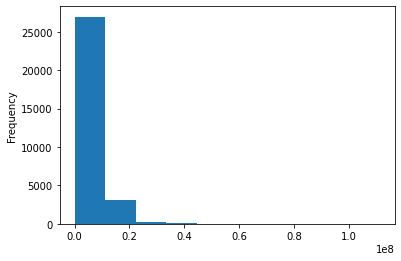

In [21]:
y.plot(kind="hist")

In [ ]:
lrstypes = ["constant", "invscaling", "annealing", "adaptive"]
means = []

for l in lrstypes:
    nn = NeuralNetwork(layers=3, nnodes=75, batchSize=75, 
                       activationFn="tanh", lr=.0000001, lr_type=l, 
                       max_epoch=2000, momentum=0.9, early_stopping=True)
    nn.fit(X_std, y_adjust)
    mae = mean_absolute_error(y_adjust, nn.predict(X_std))*100000
    means.append(mae)

means

epoch: 0
training loss: 3706.2885191182563
validation loss: 3378.948067945886
epoch: 1
training loss: 3702.40387178552
validation loss: 3380.2344524640284
epoch: 2
training loss: 3698.368373558642
validation loss: 3381.6717667815524
epoch: 3
training loss: 3694.1383174756274
validation loss: 3383.2630555302703
epoch: 4
training loss: 3689.6682921870843
validation loss: 3385.012112852429
epoch: 5
training loss: 3684.910803386941
validation loss: 3386.9233591771317
epoch: 6
training loss: 3679.815941782296
validation loss: 3389.001710172531
epoch: 7
training loss: 3674.3311078427687
validation loss: 3391.2524338554704
epoch: 8
training loss: 3668.4008061493264
validation loss: 3393.68099250713
epoch: 9
training loss: 3661.9665243167824
validation loss: 3396.292866934064
epoch: 10
training loss: 3654.9667126301015
validation loss: 3399.0933617416235
epoch: 11
training loss: 3647.3368798987267
validation loss: 3402.08739158479
epoch: 12
training loss: 3639.009817514784
validation loss: 340

epoch: 144
training loss: 1020.3759788813904
validation loss: 1046.723767806126
epoch: 145
training loss: 1018.2455480615587
validation loss: 1044.1759697878579
epoch: 146
training loss: 1016.0957577814913
validation loss: 1041.6836276534934
epoch: 147
training loss: 1013.9271418232432
validation loss: 1039.271165078571
epoch: 148
training loss: 1011.7413078164542
validation loss: 1036.9640480580597
epoch: 149
training loss: 1009.5409731041458
validation loss: 1034.787540192247
epoch: 150
training loss: 1007.3299315169799
validation loss: 1032.7651412022694
epoch: 151
training loss: 1005.1129330472588
validation loss: 1030.9168008756164
epoch: 152
training loss: 1002.8954667566746
validation loss: 1029.2570750980683
epoch: 153
training loss: 1000.6834518525991
validation loss: 1027.7934587340596
epoch: 154
training loss: 998.482860965561
validation loss: 1026.5251683231186
epoch: 155
training loss: 996.2993187111939
validation loss: 1025.4426316149045
epoch: 156
training loss: 994.1377

epoch: 248
training loss: 850.6630264557144
validation loss: 939.5198185494172
epoch: 249
training loss: 849.4634113214764
validation loss: 938.6179557835874
epoch: 250
training loss: 848.2711066268424
validation loss: 937.7170692356235
epoch: 251
training loss: 847.086078125564
validation loss: 936.8172402631308
epoch: 252
training loss: 845.9082872725747
validation loss: 935.9185550494984
epoch: 253
training loss: 844.7376915036997
validation loss: 935.0211040877466
epoch: 254
training loss: 843.574244523475
validation loss: 934.1249816689102
epoch: 255
training loss: 842.4178965974535
validation loss: 933.2302853796007
epoch: 256
training loss: 841.2685948457903
validation loss: 932.3371156128853
epoch: 257
training loss: 840.1262835352992
validation loss: 931.4455750960591
epoch: 258
training loss: 838.9909043675059
validation loss: 930.5557684382222
epoch: 259
training loss: 837.8623967605441
validation loss: 929.6678016998623
epoch: 260
training loss: 836.740698123022
validation 

epoch: 352
training loss: 754.8147678905203
validation loss: 863.5433128072916
epoch: 353
training loss: 754.0927888792028
validation loss: 863.0176870178044
epoch: 354
training loss: 753.3734977388384
validation loss: 862.4951359239576
epoch: 355
training loss: 752.6568751720436
validation loss: 861.9756137218698
epoch: 356
training loss: 751.9429026925518
validation loss: 861.4590732797163
epoch: 357
training loss: 751.2315623727725
validation loss: 860.9454670029293
epoch: 358
training loss: 750.5228363909257
validation loss: 860.4347480329409
epoch: 359
training loss: 749.8167063973167
validation loss: 859.9268716077598
epoch: 360
training loss: 749.1131527735471
validation loss: 859.4217963115105
epoch: 361
training loss: 748.4121539029293
validation loss: 858.9194849239681
epoch: 362
training loss: 747.7136855965533
validation loss: 858.4199046851709
epoch: 363
training loss: 747.017720843407
validation loss: 857.9230269854706
epoch: 364
training loss: 746.3242301133329
validatio

epoch: 456
training loss: 691.6069263487448
validation loss: 820.9033879967783
epoch: 457
training loss: 691.0941505679253
validation loss: 820.5817606129709
epoch: 458
training loss: 690.5828592636717
validation loss: 820.2614291576084
epoch: 459
training loss: 690.0730456789389
validation loss: 819.942386269417
epoch: 460
training loss: 689.5647031232409
validation loss: 819.6246246688542
epoch: 461
training loss: 689.0578249718453
validation loss: 819.3081371567197
epoch: 462
training loss: 688.5524046649765
validation loss: 818.9929166128065
epoch: 463
training loss: 688.0484357070281
validation loss: 818.6789559945832
epoch: 464
training loss: 687.5459116657819
validation loss: 818.3662483359147
epoch: 465
training loss: 687.0448261716346
validation loss: 818.054786745815
epoch: 466
training loss: 686.5451729168278
validation loss: 817.7445644072349
epoch: 467
training loss: 686.0469456546859
validation loss: 817.4355745758795
epoch: 468
training loss: 685.5501381988548
validation

epoch: 560
training loss: 645.2366747793578
validation loss: 793.3413776600072
epoch: 561
training loss: 644.8508911209365
validation loss: 793.1257601615579
epoch: 562
training loss: 644.4661187076691
validation loss: 792.9109523730838
epoch: 563
training loss: 644.0823541683366
validation loss: 792.6969509037561
epoch: 564
training loss: 643.6995941371885
validation loss: 792.4837523549994
epoch: 565
training loss: 643.3178352542624
validation loss: 792.2713533208042
epoch: 566
training loss: 642.9370741657291
validation loss: 792.0597503880736
epoch: 567
training loss: 642.5573075242423
validation loss: 791.8489401369587
epoch: 568
training loss: 642.1785319892551
validation loss: 791.6389191411471
epoch: 569
training loss: 641.8007442272778
validation loss: 791.4296839680587
epoch: 570
training loss: 641.423940912048
validation loss: 791.2212311789272
epoch: 571
training loss: 641.0481187245922
validation loss: 791.0135573287414
epoch: 572
training loss: 640.6732743531662
validatio

epoch: 665
training loss: 609.633450088417
validation loss: 774.4653471615554
epoch: 666
training loss: 609.3359503399905
validation loss: 774.3158567177596
epoch: 667
training loss: 609.0391229905641
validation loss: 774.1668329471505
epoch: 668
training loss: 608.742965106148
validation loss: 774.0182735442295
epoch: 669
training loss: 608.4474737637196
validation loss: 773.8701762275559
epoch: 670
training loss: 608.1526460512669
validation loss: 773.7225387395655
epoch: 671
training loss: 607.8584790678266
validation loss: 773.5753588463883
epoch: 672
training loss: 607.564969923522
validation loss: 773.4286343376674
epoch: 673
training loss: 607.2721157395974
validation loss: 773.2823630263796
epoch: 674
training loss: 606.9799136484538
validation loss: 773.1365427486573
epoch: 675
training loss: 606.6883607936841
validation loss: 772.9911713636144
epoch: 676
training loss: 606.397454330108
validation loss: 772.8462467531734
epoch: 677
training loss: 606.1071914238103
validation l

epoch: 770
training loss: 581.5742538703005
validation loss: 760.9839926167855
epoch: 771
training loss: 581.333609245172
validation loss: 760.8746463889318
epoch: 772
training loss: 581.09339612454
validation loss: 760.7656251786207
epoch: 773
training loss: 580.8536128500871
validation loss: 760.656928279601
epoch: 774
training loss: 580.6142577736139
validation loss: 760.548554992034
epoch: 775
training loss: 580.375329257008
validation loss: 760.4405046224181
epoch: 776
training loss: 580.1368256722096
validation loss: 760.3327764835173
epoch: 777
training loss: 579.8987454011776
validation loss: 760.2253698943007
epoch: 778
training loss: 579.6610868358564
validation loss: 760.1182841798802
epoch: 779
training loss: 579.4238483781407
validation loss: 760.0115186714669
epoch: 780
training loss: 579.1870284398418
validation loss: 759.9050727063296
epoch: 781
training loss: 578.9506254426543
validation loss: 759.7989456277704
epoch: 782
training loss: 578.7146378181253
validation los

epoch: 875
training loss: 558.4023151991573
validation loss: 751.1910100456794
epoch: 876
training loss: 558.1998371177424
validation loss: 751.1133534740068
epoch: 877
training loss: 557.9976661939559
validation loss: 751.0359628896167
epoch: 878
training loss: 557.7958015238364
validation loss: 750.9588376379191
epoch: 879
training loss: 557.5942422084498
validation loss: 750.8819770853852
epoch: 880
training loss: 557.3929873537381
validation loss: 750.8053806168424
epoch: 881
training loss: 557.1920360703774
validation loss: 750.7290476329636
epoch: 882
training loss: 556.9913874736446
validation loss: 750.6529775479453
epoch: 883
training loss: 556.7910406832926
validation loss: 750.577169787377
epoch: 884
training loss: 556.5909948234306
validation loss: 750.5016237862916
epoch: 885
training loss: 556.3912490224145
validation loss: 750.4263389873953
epoch: 886
training loss: 556.1918024127394
validation loss: 750.3513148394663
epoch: 887
training loss: 555.9926541309402
validatio

epoch: 979
training loss: 538.8406054267205
validation loss: 744.429662592312
epoch: 980
training loss: 538.6658110579398
validation loss: 744.3763757965972
epoch: 981
training loss: 538.4912465069698
validation loss: 744.3232915726703
epoch: 982
training loss: 538.3169111834186
validation loss: 744.2704094421825
epoch: 983
training loss: 538.1428044892341
validation loss: 744.2177289141567
epoch: 984
training loss: 537.9689258178096
validation loss: 744.1652494833984
epoch: 985
training loss: 537.7952745532148
validation loss: 744.1129706291375
epoch: 986
training loss: 537.6218500695587
validation loss: 744.0608918139117
epoch: 987
training loss: 537.4486517304882
validation loss: 744.0090124827097
epoch: 988
training loss: 537.2756788888203
validation loss: 743.9573320623801
epoch: 989
training loss: 537.1029308863094
validation loss: 743.905849961308
epoch: 990
training loss: 536.9304070535421
validation loss: 743.854565569357
epoch: 991
training loss: 536.7581067099594
validation 

epoch: 1083
training loss: 521.7921499396549
validation loss: 739.8656947282249
epoch: 1084
training loss: 521.6384480581056
validation loss: 739.8302499797062


In [ ]:
means

## Mean Absolute Error of Housing Predictions

In [12]:
mae = mean_absolute_error(y, nn.predict(X_std))
print('Mean absolute error: $%0.2f'%(mae*1000))

Mean absolute error: $6125120829.72


Compare these to results to those in nn_tuning_example.ipynb.  Goal: Get MAE Under $1000 with our NN.  Then, we know our NN is working well and can use it on the dataset for this project.

## Compare to Linear Regression

In [6]:
class LR:
    
    def fit(self, X_train, y_train):
        # create vector of ones...
        ones = np.ones(shape=len(X_train))[..., None]
        #...and add to feature matrix
        X = np.concatenate((ones, X_train), 1)
        #calculate coefficients using closed-form solution
        self.coeffs = np.linalg.inv(X.transpose().dot(X)).dot(X.transpose()).dot(y_train)
        
    def predict(self, X_test):
        ones = np.ones(shape=len(X_test))[..., None]
        X_test = np.concatenate((ones, X_test), 1)
        y_hat = X_test.dot(self.coeffs)
        return y_hat

## Linear Regression MAE

In [7]:
lr = LR()
lr.fit(X_std, y)
mae = mean_absolute_error(y, lr.predict(X_std))
print('Mean absolute error: $%0.2f'%(mae*1000))

Mean absolute error: $2312733180.23


In [ ]:
2312733180.23
6215120.875882364
6125120829.72

In [ ]:
6492759.066518886, 
6097805.846057779, 
6198530.949583186, 
6158860.9105913825, 
7111780.459290973, 
6958060.4762852825, 
6050248.423598237, 
6215120.875882364, 
6676444.162470134, 
6168218.017111915, 
6106309.475293339, 
6073935.760516125

6261672.852810156,
6339584.203572352,
6126601.5136576835,
6119698.301655335,
6239534.332500497